<a href="https://colab.research.google.com/github/RyosukeHanaoka/jcr2025/blob/main/swin_transformer_20241220.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.optim import AdamW
from torchvision import transforms

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.6, 0.3, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/matched_patient'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/image_nonRA'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

In [16]:
batch_size=64
epochs = 300
lr = 0.1*3e-4
gamma = 0.8
seed = 42
#dropout_of_model('swin_base_patch4_window7_224.ms_in1k')
drop_rate=0.5
attn_drop_rate=0.4
drop_path_rate=0.4
mixup_alpha=0.5
#optimizer's_settings(AdamW)
weight_decay=6e-3
#scheduler's_settings(CosineAnnealingWarmRestarts)
T_0=100
T_mult=2
eta_min=1e-7

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)
device = 'cuda'

train_transforms=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    # transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"
class RAImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)
        # 明示的にクラスとインデックスのマッピングを設定
        self.class_to_idx = {'nonRA_Right_Hand': 0, 'RA_Right_Hand': 1}

        # samplesとtargetsを更新
        self.samples = [(path, self.class_to_idx[path.split('/')[-2]])
                       for path, _ in self.samples]
        self.targets = [s[1] for s in self.samples]

    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            img = self.loader(path)
            if self.transform is not None:
                img = self.transform(img)
            return img, target
        except UnidentifiedImageError:
            print(f"Error loading image: {path}")
            img = Image.new('RGB', (224, 224), color='gray')
            if self.transform:
                img = self.transform(img)
            return img, target  # 元のターゲットを保持

# データセットの作成を変更
train_dataset = RAImageFolder(train_dir, transform=train_transforms)
valid_dataset = RAImageFolder(val_dir, transform=val_transforms)
test_dataset = RAImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
model = timm.create_model(
    'swin_base_patch4_window7_224.ms_in1k',
    pretrained=True,
    num_classes=2,
    drop_block_rate=None,
    drop_connect_rate=None,
    drop_rate=drop_rate,
    attn_drop_rate=attn_drop_rate,
    drop_path_rate=drop_path_rate,
)
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
# criterion = nn.HuberLoss()
# optimizer
optimizer = AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingWarmRestarts
"""
# Warmupスケジューラーの設定
warmup_epochs = 15
warmup_scheduler = LinearLR(
    optimizer,
    start_factor=1e-6/lr,  # 初期学習率/目標学習率
    end_factor=1.0,
    total_iters=warmup_epochs
)

# メインのスケジューラー（既存のCosineAnnealingWarmRestarts）
cosine_scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=T_0,
    T_mult=T_mult,
    eta_min=eta_min
)

# 二つのスケジューラーを結合
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_epochs]
)
"""
#scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=T_0,
    T_mult=T_mult,
    eta_min=eta_min
)
"""
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-5,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1000
)"""

"\nscheduler = torch.optim.lr_scheduler.OneCycleLR(\n    optimizer,\n    max_lr=1e-5,\n    epochs=epochs,\n    steps_per_epoch=len(train_loader),\n    pct_start=0.1,\n    anneal_strategy='cos',\n    div_factor=25,\n    final_div_factor=1000\n)"

学習ループを設定し、実行していく

In [17]:
import gc
from torchvision.utils import make_grid

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

class Mixup:
    def __init__(self, alpha=mixup_alpha):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    # 新しい指標のリストを追加
    val_sensitivity_list = []
    val_specificity_list = []
    val_f1_list = []
    test_sensitivity_list = []
    test_specificity_list = []
    test_f1_list = []

    scaler = torch.cuda.amp.GradScaler()
    mixup = Mixup(alpha=mixup_alpha)

    def calculate_metrics(outputs, labels):
        predictions = outputs.argmax(dim=1)
        tp = ((predictions == 1) & (labels == 1)).float().sum()
        tn = ((predictions == 0) & (labels == 0)).float().sum()
        fp = ((predictions == 1) & (labels == 0)).float().sum()
        fn = ((predictions == 0) & (labels == 1)).float().sum()

        sensitivity = tp / (tp + fn + 1e-7)
        specificity = tn / (tn + fp + 1e-7)
        precision = tp / (tp + fp + 1e-7)
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-7)

        return sensitivity.item(), specificity.item(), f1_score.item()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                mixed_data, labels_a, labels_b, lam = mixup(data, label)

                output = model(mixed_data)
                loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1 - lam)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            acc = (lam * (output.argmax(dim=1) == labels_a).float() +
                  (1 - lam) * (output.argmax(dim=1) == labels_b).float()).mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, mixed_data, labels_a, labels_b, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            val_outputs = []
            val_labels = []

            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                val_outputs.append(val_output)
                val_labels.append(label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # 検証データセット全体での指標計算
            val_outputs = torch.cat(val_outputs)
            val_labels = torch.cat(val_labels)
            val_sensitivity, val_specificity, val_f1 = calculate_metrics(val_outputs, val_labels)

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            test_outputs = []
            test_labels = []

            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                test_outputs.append(test_output)
                test_labels.append(label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            # テストデータセット全体での指標計算
            test_outputs = torch.cat(test_outputs)
            test_labels = torch.cat(test_labels)
            test_sensitivity, test_specificity, test_f1 = calculate_metrics(test_outputs, test_labels)

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        # 新しい指標の記録
        val_sensitivity_list.append(val_sensitivity)
        val_specificity_list.append(val_specificity)
        val_f1_list.append(val_f1)
        test_sensitivity_list.append(test_sensitivity)
        test_specificity_list.append(test_specificity)
        test_f1_list.append(test_f1)

        print(
            f"Epoch : {epoch+1} - "
            f"train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"val_sensitivity: {val_sensitivity:.4f} - val_specificity: {val_specificity:.4f} - val_f1: {val_f1:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f} - "
            f"test_sensitivity: {test_sensitivity:.4f} - test_specificity: {test_specificity:.4f} - test_f1: {test_f1:.4f}\n"
        )

        scheduler.step()

    return (train_acc_list, val_acc_list, test_acc_list,
            train_loss_list, val_loss_list, test_loss_list,
            val_sensitivity_list, val_specificity_list, val_f1_list,
            test_sensitivity_list, test_specificity_list, test_f1_list)

# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model

def main():
    model = optimize_model_settings()
    metrics = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return (model, *metrics)

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list, \
    val_sensitivity_list, val_specificity_list, val_f1_list, \
    test_sensitivity_list, test_specificity_list, test_f1_list = main()

<ipython-input-17-ad02b673bba0>:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-17-ad02b673bba0>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 1 - train_loss : 0.7356 - train_acc: 0.4996 - val_loss : 0.6744 - val_acc: 0.6600 - val_sensitivity: 0.7957 - val_specificity: 0.5000 - val_f1: 0.7081 - test_loss : 0.7306 - test_acc: 0.4047 - test_sensitivity: 0.7714 - test_specificity: 0.3824 - test_f1: 0.6506



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 0.6900 - train_acc: 0.5551 - val_loss : 0.6709 - val_acc: 0.6200 - val_sensitivity: 0.9247 - val_specificity: 0.3095 - val_f1: 0.7257 - test_loss : 0.7565 - test_acc: 0.2891 - test_sensitivity: 0.8286 - test_specificity: 0.2353 - test_f1: 0.6444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 0.6889 - train_acc: 0.5532 - val_loss : 0.6690 - val_acc: 0.6116 - val_sensitivity: 0.9462 - val_specificity: 0.2738 - val_f1: 0.7273 - test_loss : 0.7799 - test_acc: 0.2969 - test_sensitivity: 0.8571 - test_specificity: 0.2353 - test_f1: 0.6593



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 0.6684 - train_acc: 0.6060 - val_loss : 0.6623 - val_acc: 0.6368 - val_sensitivity: 0.9032 - val_specificity: 0.3571 - val_f1: 0.7273 - test_loss : 0.7792 - test_acc: 0.2891 - test_sensitivity: 0.8286 - test_specificity: 0.2353 - test_f1: 0.6444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 0.6706 - train_acc: 0.6020 - val_loss : 0.6573 - val_acc: 0.6436 - val_sensitivity: 0.9032 - val_specificity: 0.3690 - val_f1: 0.7304 - test_loss : 0.7914 - test_acc: 0.3047 - test_sensitivity: 0.8857 - test_specificity: 0.2353 - test_f1: 0.6739



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 0.6750 - train_acc: 0.5620 - val_loss : 0.6545 - val_acc: 0.6488 - val_sensitivity: 0.9140 - val_specificity: 0.3690 - val_f1: 0.7359 - test_loss : 0.8122 - test_acc: 0.3047 - test_sensitivity: 0.8857 - test_specificity: 0.2353 - test_f1: 0.6739



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 7 - train_loss : 0.6653 - train_acc: 0.5879 - val_loss : 0.6490 - val_acc: 0.6504 - val_sensitivity: 0.8925 - val_specificity: 0.3929 - val_f1: 0.7313 - test_loss : 0.8208 - test_acc: 0.3203 - test_sensitivity: 0.8857 - test_specificity: 0.2941 - test_f1: 0.6889



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 8 - train_loss : 0.6689 - train_acc: 0.5864 - val_loss : 0.6434 - val_acc: 0.6780 - val_sensitivity: 0.9032 - val_specificity: 0.4405 - val_f1: 0.7500 - test_loss : 0.8220 - test_acc: 0.3203 - test_sensitivity: 0.8857 - test_specificity: 0.2941 - test_f1: 0.6889



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 9 - train_loss : 0.6651 - train_acc: 0.6194 - val_loss : 0.6374 - val_acc: 0.6812 - val_sensitivity: 0.8387 - val_specificity: 0.5119 - val_f1: 0.7358 - test_loss : 0.8149 - test_acc: 0.3281 - test_sensitivity: 0.8857 - test_specificity: 0.3235 - test_f1: 0.6966



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 10 - train_loss : 0.6636 - train_acc: 0.6249 - val_loss : 0.6367 - val_acc: 0.6953 - val_sensitivity: 0.8925 - val_specificity: 0.4881 - val_f1: 0.7580 - test_loss : 0.8240 - test_acc: 0.3281 - test_sensitivity: 0.8857 - test_specificity: 0.3235 - test_f1: 0.6966



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 11 - train_loss : 0.6494 - train_acc: 0.6463 - val_loss : 0.6327 - val_acc: 0.6953 - val_sensitivity: 0.8710 - val_specificity: 0.5119 - val_f1: 0.7535 - test_loss : 0.8209 - test_acc: 0.3281 - test_sensitivity: 0.8857 - test_specificity: 0.3235 - test_f1: 0.6966



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 12 - train_loss : 0.6600 - train_acc: 0.6155 - val_loss : 0.6234 - val_acc: 0.6996 - val_sensitivity: 0.7634 - val_specificity: 0.6190 - val_f1: 0.7245 - test_loss : 0.7784 - test_acc: 0.3516 - test_sensitivity: 0.8286 - test_specificity: 0.4706 - test_f1: 0.7073



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 13 - train_loss : 0.6279 - train_acc: 0.6643 - val_loss : 0.6220 - val_acc: 0.6964 - val_sensitivity: 0.7849 - val_specificity: 0.5952 - val_f1: 0.7300 - test_loss : 0.7858 - test_acc: 0.3516 - test_sensitivity: 0.8286 - test_specificity: 0.4706 - test_f1: 0.7073



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 14 - train_loss : 0.6387 - train_acc: 0.6472 - val_loss : 0.6201 - val_acc: 0.6948 - val_sensitivity: 0.8065 - val_specificity: 0.5714 - val_f1: 0.7353 - test_loss : 0.7926 - test_acc: 0.3281 - test_sensitivity: 0.8286 - test_specificity: 0.3824 - test_f1: 0.6824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 15 - train_loss : 0.6628 - train_acc: 0.6247 - val_loss : 0.6210 - val_acc: 0.6984 - val_sensitivity: 0.8387 - val_specificity: 0.5476 - val_f1: 0.7464 - test_loss : 0.8077 - test_acc: 0.3438 - test_sensitivity: 0.8857 - test_specificity: 0.3824 - test_f1: 0.7126



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 16 - train_loss : 0.6361 - train_acc: 0.6590 - val_loss : 0.6225 - val_acc: 0.7057 - val_sensitivity: 0.8925 - val_specificity: 0.5119 - val_f1: 0.7650 - test_loss : 0.8199 - test_acc: 0.3438 - test_sensitivity: 0.8857 - test_specificity: 0.3824 - test_f1: 0.7126



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 17 - train_loss : 0.6148 - train_acc: 0.6989 - val_loss : 0.6140 - val_acc: 0.7053 - val_sensitivity: 0.8172 - val_specificity: 0.5833 - val_f1: 0.7451 - test_loss : 0.7865 - test_acc: 0.3438 - test_sensitivity: 0.8286 - test_specificity: 0.4412 - test_f1: 0.6988



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 18 - train_loss : 0.6605 - train_acc: 0.6283 - val_loss : 0.6093 - val_acc: 0.6980 - val_sensitivity: 0.7527 - val_specificity: 0.6310 - val_f1: 0.7216 - test_loss : 0.7606 - test_acc: 0.3594 - test_sensitivity: 0.8000 - test_specificity: 0.5294 - test_f1: 0.7089



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 19 - train_loss : 0.6413 - train_acc: 0.6463 - val_loss : 0.6160 - val_acc: 0.7141 - val_sensitivity: 0.8710 - val_specificity: 0.5476 - val_f1: 0.7642 - test_loss : 0.7994 - test_acc: 0.3516 - test_sensitivity: 0.8857 - test_specificity: 0.4118 - test_f1: 0.7209



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 20 - train_loss : 0.6223 - train_acc: 0.6715 - val_loss : 0.6171 - val_acc: 0.7109 - val_sensitivity: 0.9032 - val_specificity: 0.5119 - val_f1: 0.7706 - test_loss : 0.8135 - test_acc: 0.3516 - test_sensitivity: 0.8857 - test_specificity: 0.4118 - test_f1: 0.7209



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 21 - train_loss : 0.6333 - train_acc: 0.6392 - val_loss : 0.6046 - val_acc: 0.7116 - val_sensitivity: 0.7527 - val_specificity: 0.6548 - val_f1: 0.7292 - test_loss : 0.7521 - test_acc: 0.4750 - test_sensitivity: 0.8000 - test_specificity: 0.6176 - test_f1: 0.7368



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 22 - train_loss : 0.6440 - train_acc: 0.6576 - val_loss : 0.6021 - val_acc: 0.7477 - val_sensitivity: 0.6989 - val_specificity: 0.7857 - val_f1: 0.7386 - test_loss : 0.7274 - test_acc: 0.5141 - test_sensitivity: 0.8000 - test_specificity: 0.7647 - test_f1: 0.7887



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 23 - train_loss : 0.6381 - train_acc: 0.6649 - val_loss : 0.6028 - val_acc: 0.7325 - val_sensitivity: 0.7957 - val_specificity: 0.6548 - val_f1: 0.7551 - test_loss : 0.7542 - test_acc: 0.4516 - test_sensitivity: 0.8000 - test_specificity: 0.5294 - test_f1: 0.7089



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 24 - train_loss : 0.6342 - train_acc: 0.6658 - val_loss : 0.6017 - val_acc: 0.7325 - val_sensitivity: 0.7634 - val_specificity: 0.6905 - val_f1: 0.7474 - test_loss : 0.7424 - test_acc: 0.4906 - test_sensitivity: 0.8000 - test_specificity: 0.6765 - test_f1: 0.7568



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 25 - train_loss : 0.6293 - train_acc: 0.6547 - val_loss : 0.6000 - val_acc: 0.7545 - val_sensitivity: 0.7097 - val_specificity: 0.7857 - val_f1: 0.7458 - test_loss : 0.7234 - test_acc: 0.5141 - test_sensitivity: 0.8000 - test_specificity: 0.7647 - test_f1: 0.7887



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 26 - train_loss : 0.6592 - train_acc: 0.6227 - val_loss : 0.6011 - val_acc: 0.7456 - val_sensitivity: 0.6667 - val_specificity: 0.8095 - val_f1: 0.7251 - test_loss : 0.6970 - test_acc: 0.4984 - test_sensitivity: 0.7143 - test_specificity: 0.7941 - test_f1: 0.7463



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 27 - train_loss : 0.6189 - train_acc: 0.7008 - val_loss : 0.5996 - val_acc: 0.7613 - val_sensitivity: 0.6989 - val_specificity: 0.8095 - val_f1: 0.7471 - test_loss : 0.7035 - test_acc: 0.4984 - test_sensitivity: 0.7429 - test_specificity: 0.7647 - test_f1: 0.7536



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 28 - train_loss : 0.6189 - train_acc: 0.6990 - val_loss : 0.5966 - val_acc: 0.7545 - val_sensitivity: 0.6989 - val_specificity: 0.7976 - val_f1: 0.7429 - test_loss : 0.7133 - test_acc: 0.5063 - test_sensitivity: 0.7714 - test_specificity: 0.7647 - test_f1: 0.7714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 29 - train_loss : 0.6142 - train_acc: 0.7114 - val_loss : 0.5918 - val_acc: 0.7561 - val_sensitivity: 0.6882 - val_specificity: 0.8095 - val_f1: 0.7399 - test_loss : 0.6961 - test_acc: 0.5063 - test_sensitivity: 0.7429 - test_specificity: 0.7941 - test_f1: 0.7647



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 30 - train_loss : 0.6066 - train_acc: 0.7171 - val_loss : 0.5893 - val_acc: 0.7524 - val_sensitivity: 0.6237 - val_specificity: 0.8690 - val_f1: 0.7160 - test_loss : 0.6733 - test_acc: 0.6594 - test_sensitivity: 0.5714 - test_specificity: 0.8529 - test_f1: 0.6667



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 31 - train_loss : 0.6625 - train_acc: 0.6420 - val_loss : 0.5820 - val_acc: 0.7597 - val_sensitivity: 0.6989 - val_specificity: 0.8095 - val_f1: 0.7471 - test_loss : 0.7032 - test_acc: 0.5063 - test_sensitivity: 0.7429 - test_specificity: 0.7941 - test_f1: 0.7647



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 32 - train_loss : 0.6077 - train_acc: 0.6860 - val_loss : 0.5803 - val_acc: 0.7701 - val_sensitivity: 0.7527 - val_specificity: 0.7738 - val_f1: 0.7692 - test_loss : 0.7380 - test_acc: 0.5141 - test_sensitivity: 0.8000 - test_specificity: 0.7647 - test_f1: 0.7887



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 33 - train_loss : 0.6493 - train_acc: 0.6814 - val_loss : 0.5802 - val_acc: 0.7753 - val_sensitivity: 0.7419 - val_specificity: 0.7976 - val_f1: 0.7709 - test_loss : 0.7283 - test_acc: 0.5141 - test_sensitivity: 0.8000 - test_specificity: 0.7647 - test_f1: 0.7887



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 34 - train_loss : 0.5738 - train_acc: 0.7362 - val_loss : 0.5793 - val_acc: 0.7753 - val_sensitivity: 0.7419 - val_specificity: 0.7976 - val_f1: 0.7709 - test_loss : 0.7344 - test_acc: 0.5141 - test_sensitivity: 0.8000 - test_specificity: 0.7647 - test_f1: 0.7887



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 35 - train_loss : 0.6106 - train_acc: 0.7124 - val_loss : 0.5862 - val_acc: 0.7365 - val_sensitivity: 0.8495 - val_specificity: 0.6190 - val_f1: 0.7745 - test_loss : 0.7896 - test_acc: 0.3750 - test_sensitivity: 0.8571 - test_specificity: 0.5294 - test_f1: 0.7407



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 36 - train_loss : 0.6116 - train_acc: 0.7037 - val_loss : 0.6086 - val_acc: 0.6825 - val_sensitivity: 0.9570 - val_specificity: 0.4167 - val_f1: 0.7706 - test_loss : 0.8668 - test_acc: 0.3594 - test_sensitivity: 0.9429 - test_specificity: 0.3824 - test_f1: 0.7416



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 37 - train_loss : 0.5821 - train_acc: 0.7246 - val_loss : 0.6065 - val_acc: 0.6825 - val_sensitivity: 0.9570 - val_specificity: 0.4167 - val_f1: 0.7706 - test_loss : 0.8674 - test_acc: 0.3594 - test_sensitivity: 0.9429 - test_specificity: 0.3824 - test_f1: 0.7416



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 38 - train_loss : 0.6434 - train_acc: 0.6429 - val_loss : 0.5817 - val_acc: 0.7501 - val_sensitivity: 0.8602 - val_specificity: 0.6310 - val_f1: 0.7843 - test_loss : 0.7935 - test_acc: 0.4672 - test_sensitivity: 0.8571 - test_specificity: 0.5294 - test_f1: 0.7407



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 39 - train_loss : 0.6148 - train_acc: 0.6929 - val_loss : 0.5775 - val_acc: 0.7653 - val_sensitivity: 0.8280 - val_specificity: 0.6905 - val_f1: 0.7857 - test_loss : 0.7766 - test_acc: 0.4750 - test_sensitivity: 0.8000 - test_specificity: 0.6176 - test_f1: 0.7368



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 40 - train_loss : 0.6306 - train_acc: 0.6598 - val_loss : 0.5985 - val_acc: 0.7081 - val_sensitivity: 0.9570 - val_specificity: 0.4643 - val_f1: 0.7841 - test_loss : 0.8420 - test_acc: 0.3672 - test_sensitivity: 0.9429 - test_specificity: 0.4118 - test_f1: 0.7500



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 41 - train_loss : 0.5988 - train_acc: 0.7103 - val_loss : 0.6237 - val_acc: 0.6193 - val_sensitivity: 0.9677 - val_specificity: 0.2857 - val_f1: 0.7407 - test_loss : 0.8960 - test_acc: 0.3125 - test_sensitivity: 0.9714 - test_specificity: 0.1765 - test_f1: 0.7010



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 42 - train_loss : 0.6387 - train_acc: 0.6295 - val_loss : 0.6038 - val_acc: 0.6997 - val_sensitivity: 0.9677 - val_specificity: 0.4405 - val_f1: 0.7826 - test_loss : 0.8426 - test_acc: 0.3672 - test_sensitivity: 0.9429 - test_specificity: 0.4118 - test_f1: 0.7500



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 43 - train_loss : 0.6315 - train_acc: 0.6487 - val_loss : 0.5886 - val_acc: 0.7333 - val_sensitivity: 0.9032 - val_specificity: 0.5595 - val_f1: 0.7850 - test_loss : 0.7919 - test_acc: 0.4750 - test_sensitivity: 0.9143 - test_specificity: 0.5000 - test_f1: 0.7619



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 44 - train_loss : 0.6310 - train_acc: 0.6417 - val_loss : 0.5848 - val_acc: 0.7469 - val_sensitivity: 0.8925 - val_specificity: 0.5952 - val_f1: 0.7905 - test_loss : 0.7742 - test_acc: 0.4672 - test_sensitivity: 0.8857 - test_specificity: 0.5000 - test_f1: 0.7470



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 45 - train_loss : 0.6260 - train_acc: 0.6611 - val_loss : 0.5943 - val_acc: 0.7217 - val_sensitivity: 0.9462 - val_specificity: 0.5000 - val_f1: 0.7892 - test_loss : 0.8032 - test_acc: 0.4672 - test_sensitivity: 0.9429 - test_specificity: 0.4412 - test_f1: 0.7586



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 46 - train_loss : 0.6047 - train_acc: 0.7174 - val_loss : 0.6111 - val_acc: 0.6553 - val_sensitivity: 0.9677 - val_specificity: 0.3571 - val_f1: 0.7595 - test_loss : 0.8485 - test_acc: 0.3438 - test_sensitivity: 0.9714 - test_specificity: 0.2941 - test_f1: 0.7312



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 47 - train_loss : 0.6117 - train_acc: 0.6972 - val_loss : 0.6103 - val_acc: 0.6553 - val_sensitivity: 0.9677 - val_specificity: 0.3571 - val_f1: 0.7595 - test_loss : 0.8518 - test_acc: 0.3438 - test_sensitivity: 0.9714 - test_specificity: 0.2941 - test_f1: 0.7312



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 48 - train_loss : 0.6149 - train_acc: 0.6865 - val_loss : 0.5851 - val_acc: 0.7197 - val_sensitivity: 0.9032 - val_specificity: 0.5357 - val_f1: 0.7778 - test_loss : 0.7947 - test_acc: 0.4672 - test_sensitivity: 0.9143 - test_specificity: 0.4706 - test_f1: 0.7529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 49 - train_loss : 0.6197 - train_acc: 0.6893 - val_loss : 0.5754 - val_acc: 0.7485 - val_sensitivity: 0.8710 - val_specificity: 0.6190 - val_f1: 0.7864 - test_loss : 0.7698 - test_acc: 0.4750 - test_sensitivity: 0.8857 - test_specificity: 0.5294 - test_f1: 0.7561



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 50 - train_loss : 0.5923 - train_acc: 0.7168 - val_loss : 0.5790 - val_acc: 0.7385 - val_sensitivity: 0.9032 - val_specificity: 0.5714 - val_f1: 0.7887 - test_loss : 0.7908 - test_acc: 0.4672 - test_sensitivity: 0.9143 - test_specificity: 0.4706 - test_f1: 0.7529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 51 - train_loss : 0.5919 - train_acc: 0.7150 - val_loss : 0.5841 - val_acc: 0.7217 - val_sensitivity: 0.9462 - val_specificity: 0.5000 - val_f1: 0.7892 - test_loss : 0.8143 - test_acc: 0.4672 - test_sensitivity: 0.9429 - test_specificity: 0.4412 - test_f1: 0.7586



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 52 - train_loss : 0.6111 - train_acc: 0.6989 - val_loss : 0.5831 - val_acc: 0.7285 - val_sensitivity: 0.9462 - val_specificity: 0.5119 - val_f1: 0.7928 - test_loss : 0.8153 - test_acc: 0.4672 - test_sensitivity: 0.9429 - test_specificity: 0.4412 - test_f1: 0.7586



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 53 - train_loss : 0.5997 - train_acc: 0.7361 - val_loss : 0.5756 - val_acc: 0.7369 - val_sensitivity: 0.9140 - val_specificity: 0.5595 - val_f1: 0.7907 - test_loss : 0.8024 - test_acc: 0.4750 - test_sensitivity: 0.9429 - test_specificity: 0.4706 - test_f1: 0.7674



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 54 - train_loss : 0.5762 - train_acc: 0.7303 - val_loss : 0.5624 - val_acc: 0.7537 - val_sensitivity: 0.8710 - val_specificity: 0.6310 - val_f1: 0.7902 - test_loss : 0.7680 - test_acc: 0.4906 - test_sensitivity: 0.8857 - test_specificity: 0.5882 - test_f1: 0.7750



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 55 - train_loss : 0.5796 - train_acc: 0.7260 - val_loss : 0.5586 - val_acc: 0.7673 - val_sensitivity: 0.8602 - val_specificity: 0.6667 - val_f1: 0.7960 - test_loss : 0.7583 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 56 - train_loss : 0.6043 - train_acc: 0.7004 - val_loss : 0.5612 - val_acc: 0.7605 - val_sensitivity: 0.8710 - val_specificity: 0.6429 - val_f1: 0.7941 - test_loss : 0.7674 - test_acc: 0.4906 - test_sensitivity: 0.8857 - test_specificity: 0.5882 - test_f1: 0.7750



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 57 - train_loss : 0.5785 - train_acc: 0.7338 - val_loss : 0.5659 - val_acc: 0.7469 - val_sensitivity: 0.8817 - val_specificity: 0.6071 - val_f1: 0.7885 - test_loss : 0.7813 - test_acc: 0.4828 - test_sensitivity: 0.9143 - test_specificity: 0.5294 - test_f1: 0.7711



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 58 - train_loss : 0.5635 - train_acc: 0.7546 - val_loss : 0.5660 - val_acc: 0.7625 - val_sensitivity: 0.9032 - val_specificity: 0.6190 - val_f1: 0.8038 - test_loss : 0.7830 - test_acc: 0.4906 - test_sensitivity: 0.9143 - test_specificity: 0.5588 - test_f1: 0.7805



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 59 - train_loss : 0.6237 - train_acc: 0.6869 - val_loss : 0.5634 - val_acc: 0.7573 - val_sensitivity: 0.8925 - val_specificity: 0.6190 - val_f1: 0.7981 - test_loss : 0.7721 - test_acc: 0.4906 - test_sensitivity: 0.9143 - test_specificity: 0.5588 - test_f1: 0.7805



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 60 - train_loss : 0.5945 - train_acc: 0.6994 - val_loss : 0.5564 - val_acc: 0.7830 - val_sensitivity: 0.8710 - val_specificity: 0.6905 - val_f1: 0.8100 - test_loss : 0.7454 - test_acc: 0.5141 - test_sensitivity: 0.8857 - test_specificity: 0.6765 - test_f1: 0.8052



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 61 - train_loss : 0.5527 - train_acc: 0.7706 - val_loss : 0.5520 - val_acc: 0.7913 - val_sensitivity: 0.8387 - val_specificity: 0.7381 - val_f1: 0.8083 - test_loss : 0.7280 - test_acc: 0.5141 - test_sensitivity: 0.8571 - test_specificity: 0.7059 - test_f1: 0.8000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 62 - train_loss : 0.5867 - train_acc: 0.7166 - val_loss : 0.5527 - val_acc: 0.7793 - val_sensitivity: 0.8387 - val_specificity: 0.7143 - val_f1: 0.8000 - test_loss : 0.7353 - test_acc: 0.5063 - test_sensitivity: 0.8571 - test_specificity: 0.6765 - test_f1: 0.7895



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 63 - train_loss : 0.6036 - train_acc: 0.7095 - val_loss : 0.5558 - val_acc: 0.7673 - val_sensitivity: 0.8602 - val_specificity: 0.6667 - val_f1: 0.7960 - test_loss : 0.7505 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 64 - train_loss : 0.6002 - train_acc: 0.7246 - val_loss : 0.5592 - val_acc: 0.7657 - val_sensitivity: 0.8817 - val_specificity: 0.6429 - val_f1: 0.8000 - test_loss : 0.7613 - test_acc: 0.4984 - test_sensitivity: 0.9143 - test_specificity: 0.5882 - test_f1: 0.7901



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 65 - train_loss : 0.5602 - train_acc: 0.7393 - val_loss : 0.5583 - val_acc: 0.7673 - val_sensitivity: 0.8710 - val_specificity: 0.6548 - val_f1: 0.7980 - test_loss : 0.7611 - test_acc: 0.4984 - test_sensitivity: 0.9143 - test_specificity: 0.5882 - test_f1: 0.7901



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 66 - train_loss : 0.6333 - train_acc: 0.6825 - val_loss : 0.5564 - val_acc: 0.7725 - val_sensitivity: 0.8710 - val_specificity: 0.6667 - val_f1: 0.8020 - test_loss : 0.7528 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 67 - train_loss : 0.5595 - train_acc: 0.7560 - val_loss : 0.5546 - val_acc: 0.7621 - val_sensitivity: 0.8495 - val_specificity: 0.6667 - val_f1: 0.7900 - test_loss : 0.7436 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 68 - train_loss : 0.5800 - train_acc: 0.7277 - val_loss : 0.5583 - val_acc: 0.7777 - val_sensitivity: 0.8817 - val_specificity: 0.6667 - val_f1: 0.8079 - test_loss : 0.7506 - test_acc: 0.5063 - test_sensitivity: 0.9143 - test_specificity: 0.6176 - test_f1: 0.8000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 69 - train_loss : 0.6185 - train_acc: 0.7022 - val_loss : 0.5630 - val_acc: 0.7557 - val_sensitivity: 0.9140 - val_specificity: 0.5952 - val_f1: 0.8019 - test_loss : 0.7609 - test_acc: 0.4906 - test_sensitivity: 0.9429 - test_specificity: 0.5294 - test_f1: 0.7857



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 70 - train_loss : 0.5975 - train_acc: 0.7274 - val_loss : 0.5648 - val_acc: 0.7473 - val_sensitivity: 0.9247 - val_specificity: 0.5714 - val_f1: 0.8000 - test_loss : 0.7637 - test_acc: 0.4906 - test_sensitivity: 0.9429 - test_specificity: 0.5294 - test_f1: 0.7857



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 71 - train_loss : 0.5406 - train_acc: 0.7965 - val_loss : 0.5618 - val_acc: 0.7557 - val_sensitivity: 0.9140 - val_specificity: 0.5952 - val_f1: 0.8019 - test_loss : 0.7559 - test_acc: 0.4906 - test_sensitivity: 0.9429 - test_specificity: 0.5294 - test_f1: 0.7857



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 72 - train_loss : 0.5693 - train_acc: 0.7418 - val_loss : 0.5567 - val_acc: 0.7725 - val_sensitivity: 0.8710 - val_specificity: 0.6667 - val_f1: 0.8020 - test_loss : 0.7428 - test_acc: 0.5063 - test_sensitivity: 0.9143 - test_specificity: 0.6176 - test_f1: 0.8000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 73 - train_loss : 0.6049 - train_acc: 0.7167 - val_loss : 0.5549 - val_acc: 0.7725 - val_sensitivity: 0.8710 - val_specificity: 0.6667 - val_f1: 0.8020 - test_loss : 0.7390 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 74 - train_loss : 0.5887 - train_acc: 0.7280 - val_loss : 0.5532 - val_acc: 0.7673 - val_sensitivity: 0.8602 - val_specificity: 0.6667 - val_f1: 0.7960 - test_loss : 0.7378 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 75 - train_loss : 0.5922 - train_acc: 0.6984 - val_loss : 0.5541 - val_acc: 0.7777 - val_sensitivity: 0.8817 - val_specificity: 0.6667 - val_f1: 0.8079 - test_loss : 0.7425 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 76 - train_loss : 0.5491 - train_acc: 0.7671 - val_loss : 0.5584 - val_acc: 0.7625 - val_sensitivity: 0.9140 - val_specificity: 0.6071 - val_f1: 0.8057 - test_loss : 0.7538 - test_acc: 0.4906 - test_sensitivity: 0.9143 - test_specificity: 0.5588 - test_f1: 0.7805



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 77 - train_loss : 0.5751 - train_acc: 0.7374 - val_loss : 0.5611 - val_acc: 0.7421 - val_sensitivity: 0.9140 - val_specificity: 0.5714 - val_f1: 0.7944 - test_loss : 0.7605 - test_acc: 0.4906 - test_sensitivity: 0.9429 - test_specificity: 0.5294 - test_f1: 0.7857



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 78 - train_loss : 0.5981 - train_acc: 0.7177 - val_loss : 0.5599 - val_acc: 0.7557 - val_sensitivity: 0.9140 - val_specificity: 0.5952 - val_f1: 0.8019 - test_loss : 0.7569 - test_acc: 0.4906 - test_sensitivity: 0.9429 - test_specificity: 0.5294 - test_f1: 0.7857



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 79 - train_loss : 0.5550 - train_acc: 0.7680 - val_loss : 0.5577 - val_acc: 0.7761 - val_sensitivity: 0.9032 - val_specificity: 0.6429 - val_f1: 0.8116 - test_loss : 0.7502 - test_acc: 0.4984 - test_sensitivity: 0.9143 - test_specificity: 0.5882 - test_f1: 0.7901



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 80 - train_loss : 0.6173 - train_acc: 0.6797 - val_loss : 0.5550 - val_acc: 0.7777 - val_sensitivity: 0.8817 - val_specificity: 0.6667 - val_f1: 0.8079 - test_loss : 0.7423 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 81 - train_loss : 0.5393 - train_acc: 0.7719 - val_loss : 0.5534 - val_acc: 0.7725 - val_sensitivity: 0.8602 - val_specificity: 0.6786 - val_f1: 0.8000 - test_loss : 0.7380 - test_acc: 0.5063 - test_sensitivity: 0.8857 - test_specificity: 0.6471 - test_f1: 0.7949



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 82 - train_loss : 0.5571 - train_acc: 0.7683 - val_loss : 0.5535 - val_acc: 0.7777 - val_sensitivity: 0.8710 - val_specificity: 0.6786 - val_f1: 0.8060 - test_loss : 0.7395 - test_acc: 0.5063 - test_sensitivity: 0.8857 - test_specificity: 0.6471 - test_f1: 0.7949



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 83 - train_loss : 0.5713 - train_acc: 0.7433 - val_loss : 0.5540 - val_acc: 0.7777 - val_sensitivity: 0.8817 - val_specificity: 0.6667 - val_f1: 0.8079 - test_loss : 0.7430 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 84 - train_loss : 0.5886 - train_acc: 0.7428 - val_loss : 0.5543 - val_acc: 0.7761 - val_sensitivity: 0.8925 - val_specificity: 0.6548 - val_f1: 0.8098 - test_loss : 0.7452 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 85 - train_loss : 0.6044 - train_acc: 0.7212 - val_loss : 0.5550 - val_acc: 0.7761 - val_sensitivity: 0.8925 - val_specificity: 0.6548 - val_f1: 0.8098 - test_loss : 0.7482 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 86 - train_loss : 0.5695 - train_acc: 0.7521 - val_loss : 0.5552 - val_acc: 0.7761 - val_sensitivity: 0.8925 - val_specificity: 0.6548 - val_f1: 0.8098 - test_loss : 0.7500 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 87 - train_loss : 0.6130 - train_acc: 0.6952 - val_loss : 0.5556 - val_acc: 0.7761 - val_sensitivity: 0.9032 - val_specificity: 0.6429 - val_f1: 0.8116 - test_loss : 0.7515 - test_acc: 0.4906 - test_sensitivity: 0.8857 - test_specificity: 0.5882 - test_f1: 0.7750



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 88 - train_loss : 0.5240 - train_acc: 0.7960 - val_loss : 0.5557 - val_acc: 0.7761 - val_sensitivity: 0.9032 - val_specificity: 0.6429 - val_f1: 0.8116 - test_loss : 0.7524 - test_acc: 0.4984 - test_sensitivity: 0.9143 - test_specificity: 0.5882 - test_f1: 0.7901



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 89 - train_loss : 0.5565 - train_acc: 0.7724 - val_loss : 0.5553 - val_acc: 0.7761 - val_sensitivity: 0.9032 - val_specificity: 0.6429 - val_f1: 0.8116 - test_loss : 0.7521 - test_acc: 0.4984 - test_sensitivity: 0.9143 - test_specificity: 0.5882 - test_f1: 0.7901



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 90 - train_loss : 0.6009 - train_acc: 0.7264 - val_loss : 0.5547 - val_acc: 0.7814 - val_sensitivity: 0.9032 - val_specificity: 0.6548 - val_f1: 0.8155 - test_loss : 0.7503 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 91 - train_loss : 0.6052 - train_acc: 0.7027 - val_loss : 0.5538 - val_acc: 0.7761 - val_sensitivity: 0.8925 - val_specificity: 0.6548 - val_f1: 0.8098 - test_loss : 0.7477 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 92 - train_loss : 0.5664 - train_acc: 0.7563 - val_loss : 0.5531 - val_acc: 0.7761 - val_sensitivity: 0.8925 - val_specificity: 0.6548 - val_f1: 0.8098 - test_loss : 0.7457 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 93 - train_loss : 0.5590 - train_acc: 0.7400 - val_loss : 0.5525 - val_acc: 0.7761 - val_sensitivity: 0.8925 - val_specificity: 0.6548 - val_f1: 0.8098 - test_loss : 0.7443 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 94 - train_loss : 0.5474 - train_acc: 0.7612 - val_loss : 0.5522 - val_acc: 0.7761 - val_sensitivity: 0.8925 - val_specificity: 0.6548 - val_f1: 0.8098 - test_loss : 0.7433 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 95 - train_loss : 0.5390 - train_acc: 0.7633 - val_loss : 0.5520 - val_acc: 0.7761 - val_sensitivity: 0.8925 - val_specificity: 0.6548 - val_f1: 0.8098 - test_loss : 0.7429 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 96 - train_loss : 0.5845 - train_acc: 0.7515 - val_loss : 0.5517 - val_acc: 0.7657 - val_sensitivity: 0.8710 - val_specificity: 0.6548 - val_f1: 0.7980 - test_loss : 0.7424 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 97 - train_loss : 0.5494 - train_acc: 0.7720 - val_loss : 0.5516 - val_acc: 0.7657 - val_sensitivity: 0.8710 - val_specificity: 0.6548 - val_f1: 0.7980 - test_loss : 0.7421 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 98 - train_loss : 0.5708 - train_acc: 0.7622 - val_loss : 0.5514 - val_acc: 0.7657 - val_sensitivity: 0.8710 - val_specificity: 0.6548 - val_f1: 0.7980 - test_loss : 0.7417 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 99 - train_loss : 0.6107 - train_acc: 0.6854 - val_loss : 0.5513 - val_acc: 0.7657 - val_sensitivity: 0.8710 - val_specificity: 0.6548 - val_f1: 0.7980 - test_loss : 0.7414 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 100 - train_loss : 0.5729 - train_acc: 0.7420 - val_loss : 0.5512 - val_acc: 0.7657 - val_sensitivity: 0.8710 - val_specificity: 0.6548 - val_f1: 0.7980 - test_loss : 0.7412 - test_acc: 0.4984 - test_sensitivity: 0.8857 - test_specificity: 0.6176 - test_f1: 0.7848



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 101 - train_loss : 0.5265 - train_acc: 0.8008 - val_loss : 0.5327 - val_acc: 0.8018 - val_sensitivity: 0.8495 - val_specificity: 0.7500 - val_f1: 0.8187 - test_loss : 0.7064 - test_acc: 0.5297 - test_sensitivity: 0.8857 - test_specificity: 0.7353 - test_f1: 0.8267



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 102 - train_loss : 0.5642 - train_acc: 0.7648 - val_loss : 0.5298 - val_acc: 0.7898 - val_sensitivity: 0.8602 - val_specificity: 0.7143 - val_f1: 0.8122 - test_loss : 0.7080 - test_acc: 0.5141 - test_sensitivity: 0.8857 - test_specificity: 0.6765 - test_f1: 0.8052



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 103 - train_loss : 0.5733 - train_acc: 0.7396 - val_loss : 0.5206 - val_acc: 0.7966 - val_sensitivity: 0.8602 - val_specificity: 0.7262 - val_f1: 0.8163 - test_loss : 0.6874 - test_acc: 0.6141 - test_sensitivity: 0.8857 - test_specificity: 0.7059 - test_f1: 0.8158



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 104 - train_loss : 0.5624 - train_acc: 0.7622 - val_loss : 0.5338 - val_acc: 0.7886 - val_sensitivity: 0.9355 - val_specificity: 0.6429 - val_f1: 0.8286 - test_loss : 0.7063 - test_acc: 0.5297 - test_sensitivity: 0.9429 - test_specificity: 0.6765 - test_f1: 0.8354



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 105 - train_loss : 0.6187 - train_acc: 0.6906 - val_loss : 0.5244 - val_acc: 0.7950 - val_sensitivity: 0.8495 - val_specificity: 0.7381 - val_f1: 0.8144 - test_loss : 0.6620 - test_acc: 0.6219 - test_sensitivity: 0.8857 - test_specificity: 0.7353 - test_f1: 0.8267



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 106 - train_loss : 0.5882 - train_acc: 0.7247 - val_loss : 0.5284 - val_acc: 0.7950 - val_sensitivity: 0.8495 - val_specificity: 0.7381 - val_f1: 0.8144 - test_loss : 0.6538 - test_acc: 0.6141 - test_sensitivity: 0.8571 - test_specificity: 0.7353 - test_f1: 0.8108



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 107 - train_loss : 0.5980 - train_acc: 0.6960 - val_loss : 0.5381 - val_acc: 0.7934 - val_sensitivity: 0.8710 - val_specificity: 0.7143 - val_f1: 0.8182 - test_loss : 0.6621 - test_acc: 0.6219 - test_sensitivity: 0.9143 - test_specificity: 0.7059 - test_f1: 0.8312



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 108 - train_loss : 0.5876 - train_acc: 0.7591 - val_loss : 0.5459 - val_acc: 0.8006 - val_sensitivity: 0.9247 - val_specificity: 0.6786 - val_f1: 0.8350 - test_loss : 0.6850 - test_acc: 0.6219 - test_sensitivity: 0.9143 - test_specificity: 0.7059 - test_f1: 0.8312



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 109 - train_loss : 0.6110 - train_acc: 0.6883 - val_loss : 0.5236 - val_acc: 0.8342 - val_sensitivity: 0.8065 - val_specificity: 0.8571 - val_f1: 0.8333 - test_loss : 0.6209 - test_acc: 0.7141 - test_sensitivity: 0.7714 - test_specificity: 0.8529 - test_f1: 0.8060



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 110 - train_loss : 0.6120 - train_acc: 0.6984 - val_loss : 0.5279 - val_acc: 0.8106 - val_sensitivity: 0.8925 - val_specificity: 0.7262 - val_f1: 0.8342 - test_loss : 0.6760 - test_acc: 0.6219 - test_sensitivity: 0.9143 - test_specificity: 0.7059 - test_f1: 0.8312



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 111 - train_loss : 0.5556 - train_acc: 0.7725 - val_loss : 0.5171 - val_acc: 0.8226 - val_sensitivity: 0.8710 - val_specificity: 0.7738 - val_f1: 0.8394 - test_loss : 0.6624 - test_acc: 0.6375 - test_sensitivity: 0.9143 - test_specificity: 0.7647 - test_f1: 0.8533



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 112 - train_loss : 0.6037 - train_acc: 0.7078 - val_loss : 0.5060 - val_acc: 0.8342 - val_sensitivity: 0.8065 - val_specificity: 0.8571 - val_f1: 0.8333 - test_loss : 0.6196 - test_acc: 0.7219 - test_sensitivity: 0.8000 - test_specificity: 0.8529 - test_f1: 0.8235



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 113 - train_loss : 0.5565 - train_acc: 0.7496 - val_loss : 0.5093 - val_acc: 0.8330 - val_sensitivity: 0.8710 - val_specificity: 0.7976 - val_f1: 0.8482 - test_loss : 0.6516 - test_acc: 0.6375 - test_sensitivity: 0.9143 - test_specificity: 0.7647 - test_f1: 0.8533



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 114 - train_loss : 0.5942 - train_acc: 0.7077 - val_loss : 0.5118 - val_acc: 0.8486 - val_sensitivity: 0.9247 - val_specificity: 0.7738 - val_f1: 0.8687 - test_loss : 0.6657 - test_acc: 0.6375 - test_sensitivity: 0.9143 - test_specificity: 0.7647 - test_f1: 0.8533



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 115 - train_loss : 0.5750 - train_acc: 0.7549 - val_loss : 0.4996 - val_acc: 0.8414 - val_sensitivity: 0.8495 - val_specificity: 0.8333 - val_f1: 0.8495 - test_loss : 0.6283 - test_acc: 0.7297 - test_sensitivity: 0.8571 - test_specificity: 0.8235 - test_f1: 0.8451



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 116 - train_loss : 0.5852 - train_acc: 0.7342 - val_loss : 0.5121 - val_acc: 0.8366 - val_sensitivity: 0.9355 - val_specificity: 0.7381 - val_f1: 0.8614 - test_loss : 0.6749 - test_acc: 0.6297 - test_sensitivity: 0.9143 - test_specificity: 0.7353 - test_f1: 0.8421



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 117 - train_loss : 0.5555 - train_acc: 0.7653 - val_loss : 0.5178 - val_acc: 0.8094 - val_sensitivity: 0.9462 - val_specificity: 0.6786 - val_f1: 0.8462 - test_loss : 0.6908 - test_acc: 0.5453 - test_sensitivity: 0.9714 - test_specificity: 0.7059 - test_f1: 0.8608



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 118 - train_loss : 0.6137 - train_acc: 0.7079 - val_loss : 0.5185 - val_acc: 0.7974 - val_sensitivity: 0.9462 - val_specificity: 0.6548 - val_f1: 0.8381 - test_loss : 0.6924 - test_acc: 0.5375 - test_sensitivity: 0.9714 - test_specificity: 0.6765 - test_f1: 0.8500



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 119 - train_loss : 0.5949 - train_acc: 0.7158 - val_loss : 0.5033 - val_acc: 0.8418 - val_sensitivity: 0.9247 - val_specificity: 0.7619 - val_f1: 0.8643 - test_loss : 0.6615 - test_acc: 0.6375 - test_sensitivity: 0.9143 - test_specificity: 0.7647 - test_f1: 0.8533



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 120 - train_loss : 0.5714 - train_acc: 0.7366 - val_loss : 0.5384 - val_acc: 0.7702 - val_sensitivity: 0.9677 - val_specificity: 0.5833 - val_f1: 0.8257 - test_loss : 0.7500 - test_acc: 0.5297 - test_sensitivity: 0.9714 - test_specificity: 0.6471 - test_f1: 0.8395



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 121 - train_loss : 0.5602 - train_acc: 0.7623 - val_loss : 0.5090 - val_acc: 0.8194 - val_sensitivity: 0.9247 - val_specificity: 0.7143 - val_f1: 0.8473 - test_loss : 0.7123 - test_acc: 0.5297 - test_sensitivity: 0.9429 - test_specificity: 0.6765 - test_f1: 0.8354



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 122 - train_loss : 0.5688 - train_acc: 0.7466 - val_loss : 0.5121 - val_acc: 0.8142 - val_sensitivity: 0.9247 - val_specificity: 0.7024 - val_f1: 0.8431 - test_loss : 0.7312 - test_acc: 0.5375 - test_sensitivity: 0.9714 - test_specificity: 0.6765 - test_f1: 0.8500



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 123 - train_loss : 0.5306 - train_acc: 0.7796 - val_loss : 0.5668 - val_acc: 0.7101 - val_sensitivity: 0.9677 - val_specificity: 0.4643 - val_f1: 0.7895 - test_loss : 0.8371 - test_acc: 0.4750 - test_sensitivity: 0.9714 - test_specificity: 0.4412 - test_f1: 0.7727



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 124 - train_loss : 0.6011 - train_acc: 0.6969 - val_loss : 0.5394 - val_acc: 0.7530 - val_sensitivity: 0.9570 - val_specificity: 0.5595 - val_f1: 0.8128 - test_loss : 0.7831 - test_acc: 0.5219 - test_sensitivity: 0.9714 - test_specificity: 0.6176 - test_f1: 0.8293



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 125 - train_loss : 0.5292 - train_acc: 0.7974 - val_loss : 0.5339 - val_acc: 0.7598 - val_sensitivity: 0.9570 - val_specificity: 0.5714 - val_f1: 0.8165 - test_loss : 0.7563 - test_acc: 0.5219 - test_sensitivity: 0.9714 - test_specificity: 0.6176 - test_f1: 0.8293



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 126 - train_loss : 0.6093 - train_acc: 0.7170 - val_loss : 0.5310 - val_acc: 0.7770 - val_sensitivity: 0.9570 - val_specificity: 0.6071 - val_f1: 0.8279 - test_loss : 0.7365 - test_acc: 0.5297 - test_sensitivity: 0.9714 - test_specificity: 0.6471 - test_f1: 0.8395



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 127 - train_loss : 0.5524 - train_acc: 0.7776 - val_loss : 0.5089 - val_acc: 0.8178 - val_sensitivity: 0.8925 - val_specificity: 0.7500 - val_f1: 0.8426 - test_loss : 0.6841 - test_acc: 0.5453 - test_sensitivity: 0.9143 - test_specificity: 0.7647 - test_f1: 0.8533



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 128 - train_loss : 0.5518 - train_acc: 0.7933 - val_loss : 0.5109 - val_acc: 0.8178 - val_sensitivity: 0.8925 - val_specificity: 0.7500 - val_f1: 0.8426 - test_loss : 0.6981 - test_acc: 0.5375 - test_sensitivity: 0.9143 - test_specificity: 0.7353 - test_f1: 0.8421



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 129 - train_loss : 0.5436 - train_acc: 0.7780 - val_loss : 0.5273 - val_acc: 0.7786 - val_sensitivity: 0.9462 - val_specificity: 0.6190 - val_f1: 0.8263 - test_loss : 0.7498 - test_acc: 0.5141 - test_sensitivity: 0.9429 - test_specificity: 0.6176 - test_f1: 0.8148



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 130 - train_loss : 0.5306 - train_acc: 0.8075 - val_loss : 0.4912 - val_acc: 0.8158 - val_sensitivity: 0.8602 - val_specificity: 0.7738 - val_f1: 0.8333 - test_loss : 0.6938 - test_acc: 0.5453 - test_sensitivity: 0.9143 - test_specificity: 0.7647 - test_f1: 0.8533



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 131 - train_loss : 0.5474 - train_acc: 0.7471 - val_loss : 0.4777 - val_acc: 0.8138 - val_sensitivity: 0.8280 - val_specificity: 0.7976 - val_f1: 0.8235 - test_loss : 0.6695 - test_acc: 0.6375 - test_sensitivity: 0.8857 - test_specificity: 0.7941 - test_f1: 0.8493



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 132 - train_loss : 0.5907 - train_acc: 0.7215 - val_loss : 0.5147 - val_acc: 0.8006 - val_sensitivity: 0.9355 - val_specificity: 0.6667 - val_f1: 0.8365 - test_loss : 0.7502 - test_acc: 0.5219 - test_sensitivity: 0.9429 - test_specificity: 0.6471 - test_f1: 0.8250



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 133 - train_loss : 0.5617 - train_acc: 0.7412 - val_loss : 0.4870 - val_acc: 0.8081 - val_sensitivity: 0.7634 - val_specificity: 0.8452 - val_f1: 0.8023 - test_loss : 0.6179 - test_acc: 0.6906 - test_sensitivity: 0.6857 - test_specificity: 0.8529 - test_f1: 0.7500



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 134 - train_loss : 0.5493 - train_acc: 0.7781 - val_loss : 0.4991 - val_acc: 0.8206 - val_sensitivity: 0.8280 - val_specificity: 0.8095 - val_f1: 0.8280 - test_loss : 0.6639 - test_acc: 0.6375 - test_sensitivity: 0.8571 - test_specificity: 0.8235 - test_f1: 0.8451



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 135 - train_loss : 0.5486 - train_acc: 0.7540 - val_loss : 0.5240 - val_acc: 0.8058 - val_sensitivity: 0.9247 - val_specificity: 0.6905 - val_f1: 0.8390 - test_loss : 0.7060 - test_acc: 0.5297 - test_sensitivity: 0.9429 - test_specificity: 0.6765 - test_f1: 0.8354



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 136 - train_loss : 0.5515 - train_acc: 0.7526 - val_loss : 0.4994 - val_acc: 0.8118 - val_sensitivity: 0.7849 - val_specificity: 0.8333 - val_f1: 0.8111 - test_loss : 0.6121 - test_acc: 0.7219 - test_sensitivity: 0.8000 - test_specificity: 0.8529 - test_f1: 0.8235



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 137 - train_loss : 0.5605 - train_acc: 0.7429 - val_loss : 0.5006 - val_acc: 0.8029 - val_sensitivity: 0.7419 - val_specificity: 0.8571 - val_f1: 0.7931 - test_loss : 0.5817 - test_acc: 0.6828 - test_sensitivity: 0.6571 - test_specificity: 0.8529 - test_f1: 0.7302



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 138 - train_loss : 0.5651 - train_acc: 0.7596 - val_loss : 0.4992 - val_acc: 0.8294 - val_sensitivity: 0.8495 - val_specificity: 0.8095 - val_f1: 0.8404 - test_loss : 0.6219 - test_acc: 0.7531 - test_sensitivity: 0.9143 - test_specificity: 0.8529 - test_f1: 0.8889



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 139 - train_loss : 0.5205 - train_acc: 0.8089 - val_loss : 0.4885 - val_acc: 0.8190 - val_sensitivity: 0.8280 - val_specificity: 0.8095 - val_f1: 0.8280 - test_loss : 0.6048 - test_acc: 0.7375 - test_sensitivity: 0.8571 - test_specificity: 0.8529 - test_f1: 0.8571



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 140 - train_loss : 0.5886 - train_acc: 0.7481 - val_loss : 0.4888 - val_acc: 0.8338 - val_sensitivity: 0.7419 - val_specificity: 0.9167 - val_f1: 0.8166 - test_loss : 0.5508 - test_acc: 0.6984 - test_sensitivity: 0.6571 - test_specificity: 0.9118 - test_f1: 0.7541



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 141 - train_loss : 0.5651 - train_acc: 0.7437 - val_loss : 0.4707 - val_acc: 0.8134 - val_sensitivity: 0.7634 - val_specificity: 0.8571 - val_f1: 0.8068 - test_loss : 0.5689 - test_acc: 0.7141 - test_sensitivity: 0.7714 - test_specificity: 0.8529 - test_f1: 0.8060



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 142 - train_loss : 0.5527 - train_acc: 0.7734 - val_loss : 0.4639 - val_acc: 0.8326 - val_sensitivity: 0.8172 - val_specificity: 0.8452 - val_f1: 0.8352 - test_loss : 0.5681 - test_acc: 0.7297 - test_sensitivity: 0.8286 - test_specificity: 0.8529 - test_f1: 0.8406



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 143 - train_loss : 0.5265 - train_acc: 0.7993 - val_loss : 0.4791 - val_acc: 0.8578 - val_sensitivity: 0.7419 - val_specificity: 0.9643 - val_f1: 0.8364 - test_loss : 0.5163 - test_acc: 0.6984 - test_sensitivity: 0.6571 - test_specificity: 0.9118 - test_f1: 0.7541



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 144 - train_loss : 0.5699 - train_acc: 0.7405 - val_loss : 0.4575 - val_acc: 0.8478 - val_sensitivity: 0.7849 - val_specificity: 0.9048 - val_f1: 0.8391 - test_loss : 0.5264 - test_acc: 0.7297 - test_sensitivity: 0.8000 - test_specificity: 0.8824 - test_f1: 0.8358



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 145 - train_loss : 0.5596 - train_acc: 0.7765 - val_loss : 0.4567 - val_acc: 0.8498 - val_sensitivity: 0.8172 - val_specificity: 0.8810 - val_f1: 0.8492 - test_loss : 0.5245 - test_acc: 0.7453 - test_sensitivity: 0.8571 - test_specificity: 0.8824 - test_f1: 0.8696



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 146 - train_loss : 0.5842 - train_acc: 0.7316 - val_loss : 0.4760 - val_acc: 0.8630 - val_sensitivity: 0.7527 - val_specificity: 0.9643 - val_f1: 0.8434 - test_loss : 0.4940 - test_acc: 0.7984 - test_sensitivity: 0.6571 - test_specificity: 0.9412 - test_f1: 0.7667



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 147 - train_loss : 0.5238 - train_acc: 0.8011 - val_loss : 0.4624 - val_acc: 0.8410 - val_sensitivity: 0.7742 - val_specificity: 0.9048 - val_f1: 0.8324 - test_loss : 0.5092 - test_acc: 0.7219 - test_sensitivity: 0.7714 - test_specificity: 0.8824 - test_f1: 0.8182



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 148 - train_loss : 0.5233 - train_acc: 0.8102 - val_loss : 0.4650 - val_acc: 0.8462 - val_sensitivity: 0.7849 - val_specificity: 0.9048 - val_f1: 0.8391 - test_loss : 0.5142 - test_acc: 0.7141 - test_sensitivity: 0.7429 - test_specificity: 0.8824 - test_f1: 0.8000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 149 - train_loss : 0.6016 - train_acc: 0.7076 - val_loss : 0.4685 - val_acc: 0.8462 - val_sensitivity: 0.7957 - val_specificity: 0.8929 - val_f1: 0.8409 - test_loss : 0.5226 - test_acc: 0.7141 - test_sensitivity: 0.7429 - test_specificity: 0.8824 - test_f1: 0.8000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 150 - train_loss : 0.5230 - train_acc: 0.7964 - val_loss : 0.4751 - val_acc: 0.8510 - val_sensitivity: 0.7527 - val_specificity: 0.9405 - val_f1: 0.8333 - test_loss : 0.5219 - test_acc: 0.7141 - test_sensitivity: 0.7429 - test_specificity: 0.8824 - test_f1: 0.8000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 151 - train_loss : 0.5108 - train_acc: 0.8187 - val_loss : 0.4743 - val_acc: 0.8410 - val_sensitivity: 0.7849 - val_specificity: 0.8929 - val_f1: 0.8343 - test_loss : 0.5419 - test_acc: 0.7141 - test_sensitivity: 0.7429 - test_specificity: 0.8824 - test_f1: 0.8000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 152 - train_loss : 0.5575 - train_acc: 0.7673 - val_loss : 0.4732 - val_acc: 0.8378 - val_sensitivity: 0.8280 - val_specificity: 0.8452 - val_f1: 0.8415 - test_loss : 0.5650 - test_acc: 0.7609 - test_sensitivity: 0.9143 - test_specificity: 0.8824 - test_f1: 0.9014



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 153 - train_loss : 0.5415 - train_acc: 0.7751 - val_loss : 0.4712 - val_acc: 0.8378 - val_sensitivity: 0.8280 - val_specificity: 0.8452 - val_f1: 0.8415 - test_loss : 0.5703 - test_acc: 0.7531 - test_sensitivity: 0.8857 - test_specificity: 0.8824 - test_f1: 0.8857



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 154 - train_loss : 0.5073 - train_acc: 0.8190 - val_loss : 0.4742 - val_acc: 0.8222 - val_sensitivity: 0.8065 - val_specificity: 0.8333 - val_f1: 0.8242 - test_loss : 0.5647 - test_acc: 0.7375 - test_sensitivity: 0.8286 - test_specificity: 0.8824 - test_f1: 0.8529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 155 - train_loss : 0.5563 - train_acc: 0.7683 - val_loss : 0.4853 - val_acc: 0.8194 - val_sensitivity: 0.8925 - val_specificity: 0.7500 - val_f1: 0.8426 - test_loss : 0.5985 - test_acc: 0.7453 - test_sensitivity: 0.9143 - test_specificity: 0.8235 - test_f1: 0.8767



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 156 - train_loss : 0.5242 - train_acc: 0.7929 - val_loss : 0.4745 - val_acc: 0.8342 - val_sensitivity: 0.8172 - val_specificity: 0.8452 - val_f1: 0.8352 - test_loss : 0.5673 - test_acc: 0.7375 - test_sensitivity: 0.8286 - test_specificity: 0.8824 - test_f1: 0.8529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 157 - train_loss : 0.5531 - train_acc: 0.7708 - val_loss : 0.4704 - val_acc: 0.8326 - val_sensitivity: 0.8280 - val_specificity: 0.8333 - val_f1: 0.8370 - test_loss : 0.5744 - test_acc: 0.7453 - test_sensitivity: 0.8857 - test_specificity: 0.8529 - test_f1: 0.8732



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 158 - train_loss : 0.5249 - train_acc: 0.7920 - val_loss : 0.4777 - val_acc: 0.8334 - val_sensitivity: 0.9355 - val_specificity: 0.7381 - val_f1: 0.8614 - test_loss : 0.6202 - test_acc: 0.6531 - test_sensitivity: 0.9429 - test_specificity: 0.7941 - test_f1: 0.8800



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 159 - train_loss : 0.5514 - train_acc: 0.7615 - val_loss : 0.4536 - val_acc: 0.8446 - val_sensitivity: 0.8280 - val_specificity: 0.8571 - val_f1: 0.8462 - test_loss : 0.5636 - test_acc: 0.7531 - test_sensitivity: 0.8857 - test_specificity: 0.8824 - test_f1: 0.8857



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 160 - train_loss : 0.5198 - train_acc: 0.8076 - val_loss : 0.4530 - val_acc: 0.8446 - val_sensitivity: 0.8280 - val_specificity: 0.8571 - val_f1: 0.8462 - test_loss : 0.5575 - test_acc: 0.7531 - test_sensitivity: 0.8857 - test_specificity: 0.8824 - test_f1: 0.8857



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 161 - train_loss : 0.5134 - train_acc: 0.8134 - val_loss : 0.4618 - val_acc: 0.8398 - val_sensitivity: 0.8710 - val_specificity: 0.8095 - val_f1: 0.8526 - test_loss : 0.5810 - test_acc: 0.7531 - test_sensitivity: 0.9429 - test_specificity: 0.8235 - test_f1: 0.8919



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 162 - train_loss : 0.5574 - train_acc: 0.7655 - val_loss : 0.4649 - val_acc: 0.8398 - val_sensitivity: 0.8710 - val_specificity: 0.8095 - val_f1: 0.8526 - test_loss : 0.5691 - test_acc: 0.7609 - test_sensitivity: 0.9429 - test_specificity: 0.8529 - test_f1: 0.9041



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 163 - train_loss : 0.5046 - train_acc: 0.8082 - val_loss : 0.4674 - val_acc: 0.8346 - val_sensitivity: 0.8710 - val_specificity: 0.7976 - val_f1: 0.8482 - test_loss : 0.5671 - test_acc: 0.7609 - test_sensitivity: 0.9429 - test_specificity: 0.8529 - test_f1: 0.9041



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 164 - train_loss : 0.5500 - train_acc: 0.7607 - val_loss : 0.4750 - val_acc: 0.8314 - val_sensitivity: 0.8925 - val_specificity: 0.7738 - val_f1: 0.8513 - test_loss : 0.5858 - test_acc: 0.7531 - test_sensitivity: 0.9429 - test_specificity: 0.8235 - test_f1: 0.8919



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 165 - train_loss : 0.5755 - train_acc: 0.7473 - val_loss : 0.4754 - val_acc: 0.8314 - val_sensitivity: 0.8925 - val_specificity: 0.7738 - val_f1: 0.8513 - test_loss : 0.5733 - test_acc: 0.7609 - test_sensitivity: 0.9429 - test_specificity: 0.8529 - test_f1: 0.9041



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 166 - train_loss : 0.5340 - train_acc: 0.7862 - val_loss : 0.4670 - val_acc: 0.8514 - val_sensitivity: 0.8172 - val_specificity: 0.8810 - val_f1: 0.8492 - test_loss : 0.5322 - test_acc: 0.7375 - test_sensitivity: 0.8286 - test_specificity: 0.8824 - test_f1: 0.8529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 167 - train_loss : 0.5373 - train_acc: 0.8037 - val_loss : 0.4724 - val_acc: 0.8314 - val_sensitivity: 0.8925 - val_specificity: 0.7738 - val_f1: 0.8513 - test_loss : 0.5737 - test_acc: 0.7531 - test_sensitivity: 0.9429 - test_specificity: 0.8235 - test_f1: 0.8919



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 168 - train_loss : 0.5170 - train_acc: 0.8128 - val_loss : 0.4722 - val_acc: 0.8314 - val_sensitivity: 0.9032 - val_specificity: 0.7619 - val_f1: 0.8528 - test_loss : 0.5915 - test_acc: 0.6609 - test_sensitivity: 0.9714 - test_specificity: 0.7941 - test_f1: 0.8947



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 169 - train_loss : 0.5486 - train_acc: 0.7490 - val_loss : 0.4549 - val_acc: 0.8534 - val_sensitivity: 0.8710 - val_specificity: 0.8333 - val_f1: 0.8617 - test_loss : 0.5569 - test_acc: 0.7688 - test_sensitivity: 0.9429 - test_specificity: 0.8824 - test_f1: 0.9167



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 170 - train_loss : 0.5282 - train_acc: 0.7906 - val_loss : 0.4512 - val_acc: 0.8498 - val_sensitivity: 0.8495 - val_specificity: 0.8452 - val_f1: 0.8541 - test_loss : 0.5460 - test_acc: 0.7609 - test_sensitivity: 0.9143 - test_specificity: 0.8824 - test_f1: 0.9014



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 171 - train_loss : 0.5668 - train_acc: 0.7508 - val_loss : 0.4515 - val_acc: 0.8602 - val_sensitivity: 0.8495 - val_specificity: 0.8690 - val_f1: 0.8634 - test_loss : 0.5364 - test_acc: 0.7531 - test_sensitivity: 0.8857 - test_specificity: 0.8824 - test_f1: 0.8857



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 172 - train_loss : 0.5369 - train_acc: 0.7727 - val_loss : 0.4552 - val_acc: 0.8550 - val_sensitivity: 0.8495 - val_specificity: 0.8571 - val_f1: 0.8587 - test_loss : 0.5301 - test_acc: 0.8531 - test_sensitivity: 0.8857 - test_specificity: 0.9118 - test_f1: 0.8986



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 173 - train_loss : 0.5053 - train_acc: 0.8125 - val_loss : 0.4623 - val_acc: 0.8666 - val_sensitivity: 0.7742 - val_specificity: 0.9524 - val_f1: 0.8521 - test_loss : 0.5009 - test_acc: 0.8375 - test_sensitivity: 0.8286 - test_specificity: 0.9118 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 174 - train_loss : 0.5255 - train_acc: 0.7955 - val_loss : 0.4565 - val_acc: 0.8566 - val_sensitivity: 0.8280 - val_specificity: 0.8810 - val_f1: 0.8556 - test_loss : 0.5201 - test_acc: 0.8531 - test_sensitivity: 0.8857 - test_specificity: 0.9118 - test_f1: 0.8986



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 175 - train_loss : 0.5022 - train_acc: 0.8164 - val_loss : 0.4546 - val_acc: 0.8618 - val_sensitivity: 0.8495 - val_specificity: 0.8690 - val_f1: 0.8634 - test_loss : 0.5289 - test_acc: 0.8531 - test_sensitivity: 0.8857 - test_specificity: 0.9118 - test_f1: 0.8986



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 176 - train_loss : 0.4969 - train_acc: 0.8173 - val_loss : 0.4658 - val_acc: 0.8510 - val_sensitivity: 0.7419 - val_specificity: 0.9524 - val_f1: 0.8313 - test_loss : 0.4877 - test_acc: 0.8219 - test_sensitivity: 0.7429 - test_specificity: 0.9412 - test_f1: 0.8254



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 177 - train_loss : 0.5542 - train_acc: 0.7776 - val_loss : 0.4579 - val_acc: 0.8654 - val_sensitivity: 0.8387 - val_specificity: 0.8929 - val_f1: 0.8667 - test_loss : 0.5041 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 178 - train_loss : 0.4998 - train_acc: 0.8146 - val_loss : 0.4612 - val_acc: 0.8738 - val_sensitivity: 0.8280 - val_specificity: 0.9167 - val_f1: 0.8701 - test_loss : 0.4958 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 179 - train_loss : 0.4897 - train_acc: 0.8148 - val_loss : 0.4631 - val_acc: 0.8426 - val_sensitivity: 0.7634 - val_specificity: 0.9167 - val_f1: 0.8304 - test_loss : 0.4874 - test_acc: 0.8375 - test_sensitivity: 0.8286 - test_specificity: 0.9118 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 180 - train_loss : 0.5817 - train_acc: 0.7555 - val_loss : 0.4635 - val_acc: 0.8478 - val_sensitivity: 0.7742 - val_specificity: 0.9167 - val_f1: 0.8372 - test_loss : 0.4898 - test_acc: 0.8375 - test_sensitivity: 0.8286 - test_specificity: 0.9118 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 181 - train_loss : 0.5320 - train_acc: 0.7793 - val_loss : 0.4586 - val_acc: 0.8654 - val_sensitivity: 0.8387 - val_specificity: 0.8929 - val_f1: 0.8667 - test_loss : 0.5000 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 182 - train_loss : 0.5094 - train_acc: 0.8207 - val_loss : 0.4710 - val_acc: 0.8458 - val_sensitivity: 0.7312 - val_specificity: 0.9524 - val_f1: 0.8242 - test_loss : 0.4787 - test_acc: 0.8062 - test_sensitivity: 0.7143 - test_specificity: 0.9118 - test_f1: 0.7937



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 183 - train_loss : 0.5469 - train_acc: 0.7911 - val_loss : 0.4622 - val_acc: 0.8530 - val_sensitivity: 0.7849 - val_specificity: 0.9167 - val_f1: 0.8439 - test_loss : 0.4865 - test_acc: 0.8219 - test_sensitivity: 0.7714 - test_specificity: 0.9118 - test_f1: 0.8308



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 184 - train_loss : 0.5515 - train_acc: 0.7782 - val_loss : 0.4633 - val_acc: 0.8530 - val_sensitivity: 0.7849 - val_specificity: 0.9167 - val_f1: 0.8439 - test_loss : 0.4826 - test_acc: 0.8219 - test_sensitivity: 0.7714 - test_specificity: 0.9118 - test_f1: 0.8308



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 185 - train_loss : 0.5045 - train_acc: 0.8300 - val_loss : 0.4548 - val_acc: 0.8774 - val_sensitivity: 0.8495 - val_specificity: 0.9048 - val_f1: 0.8778 - test_loss : 0.4982 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 186 - train_loss : 0.4915 - train_acc: 0.8299 - val_loss : 0.4530 - val_acc: 0.8598 - val_sensitivity: 0.7849 - val_specificity: 0.9286 - val_f1: 0.8488 - test_loss : 0.4823 - test_acc: 0.8297 - test_sensitivity: 0.8000 - test_specificity: 0.9118 - test_f1: 0.8485



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 187 - train_loss : 0.4822 - train_acc: 0.8370 - val_loss : 0.4486 - val_acc: 0.8806 - val_sensitivity: 0.8280 - val_specificity: 0.9286 - val_f1: 0.8750 - test_loss : 0.4864 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 188 - train_loss : 0.4579 - train_acc: 0.8869 - val_loss : 0.4484 - val_acc: 0.8858 - val_sensitivity: 0.8387 - val_specificity: 0.9286 - val_f1: 0.8814 - test_loss : 0.4871 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 189 - train_loss : 0.5454 - train_acc: 0.7794 - val_loss : 0.4511 - val_acc: 0.8858 - val_sensitivity: 0.8387 - val_specificity: 0.9286 - val_f1: 0.8814 - test_loss : 0.4814 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 190 - train_loss : 0.5085 - train_acc: 0.8192 - val_loss : 0.4556 - val_acc: 0.8650 - val_sensitivity: 0.7957 - val_specificity: 0.9286 - val_f1: 0.8555 - test_loss : 0.4697 - test_acc: 0.8453 - test_sensitivity: 0.8286 - test_specificity: 0.9412 - test_f1: 0.8788



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 191 - train_loss : 0.5291 - train_acc: 0.7834 - val_loss : 0.4518 - val_acc: 0.8790 - val_sensitivity: 0.8387 - val_specificity: 0.9167 - val_f1: 0.8764 - test_loss : 0.4731 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 192 - train_loss : 0.4736 - train_acc: 0.8509 - val_loss : 0.4496 - val_acc: 0.8879 - val_sensitivity: 0.8925 - val_specificity: 0.8810 - val_f1: 0.8925 - test_loss : 0.4870 - test_acc: 0.8687 - test_sensitivity: 0.9429 - test_specificity: 0.9118 - test_f1: 0.9296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 193 - train_loss : 0.5006 - train_acc: 0.8231 - val_loss : 0.4427 - val_acc: 0.8947 - val_sensitivity: 0.8710 - val_specificity: 0.9167 - val_f1: 0.8950 - test_loss : 0.4678 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 194 - train_loss : 0.5591 - train_acc: 0.7694 - val_loss : 0.4379 - val_acc: 0.8911 - val_sensitivity: 0.8495 - val_specificity: 0.9286 - val_f1: 0.8876 - test_loss : 0.4563 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 195 - train_loss : 0.5081 - train_acc: 0.8072 - val_loss : 0.4341 - val_acc: 0.8858 - val_sensitivity: 0.8387 - val_specificity: 0.9286 - val_f1: 0.8814 - test_loss : 0.4542 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 196 - train_loss : 0.5008 - train_acc: 0.8139 - val_loss : 0.4308 - val_acc: 0.8963 - val_sensitivity: 0.8602 - val_specificity: 0.9286 - val_f1: 0.8939 - test_loss : 0.4565 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 197 - train_loss : 0.4543 - train_acc: 0.8596 - val_loss : 0.4329 - val_acc: 0.8822 - val_sensitivity: 0.8172 - val_specificity: 0.9405 - val_f1: 0.8736 - test_loss : 0.4431 - test_acc: 0.8531 - test_sensitivity: 0.8571 - test_specificity: 0.9412 - test_f1: 0.8955



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 198 - train_loss : 0.5844 - train_acc: 0.7372 - val_loss : 0.4334 - val_acc: 0.8874 - val_sensitivity: 0.8280 - val_specificity: 0.9405 - val_f1: 0.8800 - test_loss : 0.4426 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 199 - train_loss : 0.5131 - train_acc: 0.8110 - val_loss : 0.4357 - val_acc: 0.8963 - val_sensitivity: 0.8602 - val_specificity: 0.9286 - val_f1: 0.8939 - test_loss : 0.4462 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 200 - train_loss : 0.4752 - train_acc: 0.8333 - val_loss : 0.4403 - val_acc: 0.8999 - val_sensitivity: 0.8817 - val_specificity: 0.9167 - val_f1: 0.9011 - test_loss : 0.4577 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 201 - train_loss : 0.4213 - train_acc: 0.8864 - val_loss : 0.4467 - val_acc: 0.8727 - val_sensitivity: 0.8925 - val_specificity: 0.8571 - val_f1: 0.8830 - test_loss : 0.4767 - test_acc: 0.8609 - test_sensitivity: 0.9143 - test_specificity: 0.9118 - test_f1: 0.9143



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 202 - train_loss : 0.5027 - train_acc: 0.8197 - val_loss : 0.4450 - val_acc: 0.8947 - val_sensitivity: 0.8710 - val_specificity: 0.9167 - val_f1: 0.8950 - test_loss : 0.4623 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 203 - train_loss : 0.5484 - train_acc: 0.7850 - val_loss : 0.4497 - val_acc: 0.8478 - val_sensitivity: 0.7742 - val_specificity: 0.9167 - val_f1: 0.8372 - test_loss : 0.4600 - test_acc: 0.8297 - test_sensitivity: 0.8000 - test_specificity: 0.9118 - test_f1: 0.8485



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 204 - train_loss : 0.5337 - train_acc: 0.7967 - val_loss : 0.4459 - val_acc: 0.8738 - val_sensitivity: 0.8280 - val_specificity: 0.9167 - val_f1: 0.8701 - test_loss : 0.4746 - test_acc: 0.8453 - test_sensitivity: 0.8571 - test_specificity: 0.9118 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 205 - train_loss : 0.5069 - train_acc: 0.7936 - val_loss : 0.4451 - val_acc: 0.8638 - val_sensitivity: 0.8817 - val_specificity: 0.8452 - val_f1: 0.8723 - test_loss : 0.5063 - test_acc: 0.8531 - test_sensitivity: 0.8857 - test_specificity: 0.9118 - test_f1: 0.8986



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 206 - train_loss : 0.4304 - train_acc: 0.8831 - val_loss : 0.4448 - val_acc: 0.8638 - val_sensitivity: 0.8817 - val_specificity: 0.8452 - val_f1: 0.8723 - test_loss : 0.5180 - test_acc: 0.8687 - test_sensitivity: 0.9429 - test_specificity: 0.9118 - test_f1: 0.9296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 207 - train_loss : 0.4735 - train_acc: 0.8444 - val_loss : 0.4372 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4860 - test_acc: 0.8531 - test_sensitivity: 0.8857 - test_specificity: 0.9118 - test_f1: 0.8986



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 208 - train_loss : 0.5336 - train_acc: 0.7811 - val_loss : 0.4399 - val_acc: 0.8718 - val_sensitivity: 0.7957 - val_specificity: 0.9405 - val_f1: 0.8605 - test_loss : 0.4610 - test_acc: 0.8453 - test_sensitivity: 0.8286 - test_specificity: 0.9412 - test_f1: 0.8788



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 209 - train_loss : 0.4920 - train_acc: 0.8288 - val_loss : 0.4393 - val_acc: 0.8702 - val_sensitivity: 0.8065 - val_specificity: 0.9286 - val_f1: 0.8621 - test_loss : 0.4580 - test_acc: 0.8453 - test_sensitivity: 0.8286 - test_specificity: 0.9412 - test_f1: 0.8788



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 210 - train_loss : 0.5243 - train_acc: 0.7971 - val_loss : 0.4405 - val_acc: 0.8811 - val_sensitivity: 0.8710 - val_specificity: 0.8929 - val_f1: 0.8852 - test_loss : 0.4657 - test_acc: 0.8531 - test_sensitivity: 0.8857 - test_specificity: 0.9118 - test_f1: 0.8986



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 211 - train_loss : 0.4797 - train_acc: 0.8585 - val_loss : 0.4457 - val_acc: 0.8811 - val_sensitivity: 0.8710 - val_specificity: 0.8929 - val_f1: 0.8852 - test_loss : 0.4596 - test_acc: 0.8687 - test_sensitivity: 0.9429 - test_specificity: 0.9118 - test_f1: 0.9296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 212 - train_loss : 0.4193 - train_acc: 0.8851 - val_loss : 0.4542 - val_acc: 0.8514 - val_sensitivity: 0.7957 - val_specificity: 0.9048 - val_f1: 0.8457 - test_loss : 0.4405 - test_acc: 0.8531 - test_sensitivity: 0.8571 - test_specificity: 0.9412 - test_f1: 0.8955



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 213 - train_loss : 0.4849 - train_acc: 0.8374 - val_loss : 0.4541 - val_acc: 0.8462 - val_sensitivity: 0.7849 - val_specificity: 0.9048 - val_f1: 0.8391 - test_loss : 0.4367 - test_acc: 0.8531 - test_sensitivity: 0.8571 - test_specificity: 0.9412 - test_f1: 0.8955



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 214 - train_loss : 0.5116 - train_acc: 0.7971 - val_loss : 0.4495 - val_acc: 0.8722 - val_sensitivity: 0.8387 - val_specificity: 0.9048 - val_f1: 0.8715 - test_loss : 0.4388 - test_acc: 0.8766 - test_sensitivity: 0.9429 - test_specificity: 0.9412 - test_f1: 0.9429



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 215 - train_loss : 0.4932 - train_acc: 0.8263 - val_loss : 0.4465 - val_acc: 0.8774 - val_sensitivity: 0.8495 - val_specificity: 0.9048 - val_f1: 0.8778 - test_loss : 0.4356 - test_acc: 0.8609 - test_sensitivity: 0.8857 - test_specificity: 0.9412 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 216 - train_loss : 0.5015 - train_acc: 0.8266 - val_loss : 0.4436 - val_acc: 0.8722 - val_sensitivity: 0.8387 - val_specificity: 0.9048 - val_f1: 0.8715 - test_loss : 0.4333 - test_acc: 0.8609 - test_sensitivity: 0.8857 - test_specificity: 0.9412 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 217 - train_loss : 0.5545 - train_acc: 0.7859 - val_loss : 0.4439 - val_acc: 0.8770 - val_sensitivity: 0.8065 - val_specificity: 0.9405 - val_f1: 0.8671 - test_loss : 0.4319 - test_acc: 0.8453 - test_sensitivity: 0.8286 - test_specificity: 0.9412 - test_f1: 0.8788



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 218 - train_loss : 0.4251 - train_acc: 0.8890 - val_loss : 0.4400 - val_acc: 0.8718 - val_sensitivity: 0.7957 - val_specificity: 0.9405 - val_f1: 0.8605 - test_loss : 0.4342 - test_acc: 0.8453 - test_sensitivity: 0.8286 - test_specificity: 0.9412 - test_f1: 0.8788



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 219 - train_loss : 0.5299 - train_acc: 0.8120 - val_loss : 0.4315 - val_acc: 0.8874 - val_sensitivity: 0.8280 - val_specificity: 0.9405 - val_f1: 0.8800 - test_loss : 0.4419 - test_acc: 0.8453 - test_sensitivity: 0.8286 - test_specificity: 0.9412 - test_f1: 0.8788



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 220 - train_loss : 0.4513 - train_acc: 0.8516 - val_loss : 0.4260 - val_acc: 0.8895 - val_sensitivity: 0.8602 - val_specificity: 0.9167 - val_f1: 0.8889 - test_loss : 0.4603 - test_acc: 0.8609 - test_sensitivity: 0.9143 - test_specificity: 0.9118 - test_f1: 0.9143



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 221 - train_loss : 0.4734 - train_acc: 0.8517 - val_loss : 0.4272 - val_acc: 0.8911 - val_sensitivity: 0.8495 - val_specificity: 0.9286 - val_f1: 0.8876 - test_loss : 0.4506 - test_acc: 0.8609 - test_sensitivity: 0.8857 - test_specificity: 0.9412 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 222 - train_loss : 0.4819 - train_acc: 0.8513 - val_loss : 0.4269 - val_acc: 0.8895 - val_sensitivity: 0.8602 - val_specificity: 0.9167 - val_f1: 0.8889 - test_loss : 0.4549 - test_acc: 0.8531 - test_sensitivity: 0.8857 - test_specificity: 0.9118 - test_f1: 0.8986



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 223 - train_loss : 0.4465 - train_acc: 0.8824 - val_loss : 0.4267 - val_acc: 0.8911 - val_sensitivity: 0.8495 - val_specificity: 0.9286 - val_f1: 0.8876 - test_loss : 0.4519 - test_acc: 0.8609 - test_sensitivity: 0.8857 - test_specificity: 0.9412 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 224 - train_loss : 0.4972 - train_acc: 0.8168 - val_loss : 0.4285 - val_acc: 0.8979 - val_sensitivity: 0.8495 - val_specificity: 0.9405 - val_f1: 0.8927 - test_loss : 0.4400 - test_acc: 0.8531 - test_sensitivity: 0.8571 - test_specificity: 0.9412 - test_f1: 0.8955



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 225 - train_loss : 0.5261 - train_acc: 0.7974 - val_loss : 0.4323 - val_acc: 0.8874 - val_sensitivity: 0.8280 - val_specificity: 0.9405 - val_f1: 0.8800 - test_loss : 0.4318 - test_acc: 0.8453 - test_sensitivity: 0.8286 - test_specificity: 0.9412 - test_f1: 0.8788



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 226 - train_loss : 0.4418 - train_acc: 0.8735 - val_loss : 0.4285 - val_acc: 0.8947 - val_sensitivity: 0.8710 - val_specificity: 0.9167 - val_f1: 0.8950 - test_loss : 0.4456 - test_acc: 0.8609 - test_sensitivity: 0.8857 - test_specificity: 0.9412 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 227 - train_loss : 0.5712 - train_acc: 0.7542 - val_loss : 0.4332 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4560 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 228 - train_loss : 0.4858 - train_acc: 0.8559 - val_loss : 0.4355 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4463 - test_acc: 0.8687 - test_sensitivity: 0.9143 - test_specificity: 0.9412 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 229 - train_loss : 0.5113 - train_acc: 0.8135 - val_loss : 0.4395 - val_acc: 0.8790 - val_sensitivity: 0.8387 - val_specificity: 0.9167 - val_f1: 0.8764 - test_loss : 0.4341 - test_acc: 0.8531 - test_sensitivity: 0.8571 - test_specificity: 0.9412 - test_f1: 0.8955



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 230 - train_loss : 0.4410 - train_acc: 0.8902 - val_loss : 0.4383 - val_acc: 0.8790 - val_sensitivity: 0.8387 - val_specificity: 0.9167 - val_f1: 0.8764 - test_loss : 0.4384 - test_acc: 0.8609 - test_sensitivity: 0.8857 - test_specificity: 0.9412 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 231 - train_loss : 0.4643 - train_acc: 0.8518 - val_loss : 0.4350 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4473 - test_acc: 0.8609 - test_sensitivity: 0.8857 - test_specificity: 0.9412 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 232 - train_loss : 0.5068 - train_acc: 0.8007 - val_loss : 0.4334 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4674 - test_acc: 0.8766 - test_sensitivity: 0.9714 - test_specificity: 0.9118 - test_f1: 0.9444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 233 - train_loss : 0.4928 - train_acc: 0.8293 - val_loss : 0.4297 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4743 - test_acc: 0.8766 - test_sensitivity: 0.9714 - test_specificity: 0.9118 - test_f1: 0.9444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 234 - train_loss : 0.5846 - train_acc: 0.7377 - val_loss : 0.4267 - val_acc: 0.8947 - val_sensitivity: 0.8710 - val_specificity: 0.9167 - val_f1: 0.8950 - test_loss : 0.4681 - test_acc: 0.8687 - test_sensitivity: 0.9143 - test_specificity: 0.9412 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 235 - train_loss : 0.4855 - train_acc: 0.8367 - val_loss : 0.4252 - val_acc: 0.9015 - val_sensitivity: 0.8710 - val_specificity: 0.9286 - val_f1: 0.9000 - test_loss : 0.4645 - test_acc: 0.8687 - test_sensitivity: 0.9143 - test_specificity: 0.9412 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 236 - train_loss : 0.5154 - train_acc: 0.8093 - val_loss : 0.4258 - val_acc: 0.8947 - val_sensitivity: 0.8710 - val_specificity: 0.9167 - val_f1: 0.8950 - test_loss : 0.4717 - test_acc: 0.8766 - test_sensitivity: 0.9714 - test_specificity: 0.9118 - test_f1: 0.9444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 237 - train_loss : 0.4885 - train_acc: 0.8330 - val_loss : 0.4297 - val_acc: 0.8690 - val_sensitivity: 0.8710 - val_specificity: 0.8690 - val_f1: 0.8757 - test_loss : 0.4938 - test_acc: 0.8766 - test_sensitivity: 0.9714 - test_specificity: 0.9118 - test_f1: 0.9444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 238 - train_loss : 0.5056 - train_acc: 0.8171 - val_loss : 0.4300 - val_acc: 0.8690 - val_sensitivity: 0.8710 - val_specificity: 0.8690 - val_f1: 0.8757 - test_loss : 0.4929 - test_acc: 0.8844 - test_sensitivity: 1.0000 - test_specificity: 0.9118 - test_f1: 0.9589



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 239 - train_loss : 0.5072 - train_acc: 0.7976 - val_loss : 0.4288 - val_acc: 0.8759 - val_sensitivity: 0.8710 - val_specificity: 0.8810 - val_f1: 0.8804 - test_loss : 0.4780 - test_acc: 0.8844 - test_sensitivity: 1.0000 - test_specificity: 0.9118 - test_f1: 0.9589



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 240 - train_loss : 0.5178 - train_acc: 0.8097 - val_loss : 0.4308 - val_acc: 0.8759 - val_sensitivity: 0.8710 - val_specificity: 0.8810 - val_f1: 0.8804 - test_loss : 0.4748 - test_acc: 0.8844 - test_sensitivity: 1.0000 - test_specificity: 0.9118 - test_f1: 0.9589



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 241 - train_loss : 0.4738 - train_acc: 0.8375 - val_loss : 0.4338 - val_acc: 0.8759 - val_sensitivity: 0.8710 - val_specificity: 0.8810 - val_f1: 0.8804 - test_loss : 0.4721 - test_acc: 0.8844 - test_sensitivity: 1.0000 - test_specificity: 0.9118 - test_f1: 0.9589



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 242 - train_loss : 0.4960 - train_acc: 0.8265 - val_loss : 0.4351 - val_acc: 0.8706 - val_sensitivity: 0.8710 - val_specificity: 0.8690 - val_f1: 0.8757 - test_loss : 0.4651 - test_acc: 0.8844 - test_sensitivity: 1.0000 - test_specificity: 0.9118 - test_f1: 0.9589



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 243 - train_loss : 0.5160 - train_acc: 0.7852 - val_loss : 0.4387 - val_acc: 0.8759 - val_sensitivity: 0.8817 - val_specificity: 0.8690 - val_f1: 0.8817 - test_loss : 0.4729 - test_acc: 0.8844 - test_sensitivity: 1.0000 - test_specificity: 0.9118 - test_f1: 0.9589



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 244 - train_loss : 0.4533 - train_acc: 0.8649 - val_loss : 0.4383 - val_acc: 0.8743 - val_sensitivity: 0.8925 - val_specificity: 0.8571 - val_f1: 0.8830 - test_loss : 0.4733 - test_acc: 0.8844 - test_sensitivity: 1.0000 - test_specificity: 0.9118 - test_f1: 0.9589



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 245 - train_loss : 0.4776 - train_acc: 0.8280 - val_loss : 0.4346 - val_acc: 0.8706 - val_sensitivity: 0.8710 - val_specificity: 0.8690 - val_f1: 0.8757 - test_loss : 0.4622 - test_acc: 0.8844 - test_sensitivity: 1.0000 - test_specificity: 0.9118 - test_f1: 0.9589



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 246 - train_loss : 0.4846 - train_acc: 0.8168 - val_loss : 0.4325 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4413 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 247 - train_loss : 0.5173 - train_acc: 0.8081 - val_loss : 0.4332 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4363 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 248 - train_loss : 0.5516 - train_acc: 0.7713 - val_loss : 0.4357 - val_acc: 0.8706 - val_sensitivity: 0.8710 - val_specificity: 0.8690 - val_f1: 0.8757 - test_loss : 0.4433 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 249 - train_loss : 0.4972 - train_acc: 0.8419 - val_loss : 0.4397 - val_acc: 0.8675 - val_sensitivity: 0.8925 - val_specificity: 0.8452 - val_f1: 0.8783 - test_loss : 0.4506 - test_acc: 0.8844 - test_sensitivity: 1.0000 - test_specificity: 0.9118 - test_f1: 0.9589



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 250 - train_loss : 0.4637 - train_acc: 0.8502 - val_loss : 0.4389 - val_acc: 0.8570 - val_sensitivity: 0.8710 - val_specificity: 0.8452 - val_f1: 0.8663 - test_loss : 0.4463 - test_acc: 0.8766 - test_sensitivity: 0.9714 - test_specificity: 0.9118 - test_f1: 0.9444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 251 - train_loss : 0.5139 - train_acc: 0.8070 - val_loss : 0.4368 - val_acc: 0.8774 - val_sensitivity: 0.8710 - val_specificity: 0.8810 - val_f1: 0.8804 - test_loss : 0.4358 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 252 - train_loss : 0.5222 - train_acc: 0.8012 - val_loss : 0.4355 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4273 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 253 - train_loss : 0.4751 - train_acc: 0.8618 - val_loss : 0.4353 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4249 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 254 - train_loss : 0.4510 - train_acc: 0.8861 - val_loss : 0.4342 - val_acc: 0.8827 - val_sensitivity: 0.8710 - val_specificity: 0.8929 - val_f1: 0.8852 - test_loss : 0.4306 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 255 - train_loss : 0.5529 - train_acc: 0.7615 - val_loss : 0.4347 - val_acc: 0.8774 - val_sensitivity: 0.8710 - val_specificity: 0.8810 - val_f1: 0.8804 - test_loss : 0.4400 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 256 - train_loss : 0.5273 - train_acc: 0.8060 - val_loss : 0.4365 - val_acc: 0.8690 - val_sensitivity: 0.8817 - val_specificity: 0.8571 - val_f1: 0.8770 - test_loss : 0.4501 - test_acc: 0.8766 - test_sensitivity: 0.9714 - test_specificity: 0.9118 - test_f1: 0.9444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 257 - train_loss : 0.4736 - train_acc: 0.8538 - val_loss : 0.4390 - val_acc: 0.8675 - val_sensitivity: 0.8925 - val_specificity: 0.8452 - val_f1: 0.8783 - test_loss : 0.4588 - test_acc: 0.8844 - test_sensitivity: 1.0000 - test_specificity: 0.9118 - test_f1: 0.9589



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 258 - train_loss : 0.4790 - train_acc: 0.8454 - val_loss : 0.4376 - val_acc: 0.8743 - val_sensitivity: 0.8925 - val_specificity: 0.8571 - val_f1: 0.8830 - test_loss : 0.4558 - test_acc: 0.8766 - test_sensitivity: 0.9714 - test_specificity: 0.9118 - test_f1: 0.9444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 259 - train_loss : 0.5297 - train_acc: 0.7915 - val_loss : 0.4348 - val_acc: 0.8706 - val_sensitivity: 0.8710 - val_specificity: 0.8690 - val_f1: 0.8757 - test_loss : 0.4492 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 260 - train_loss : 0.4763 - train_acc: 0.8538 - val_loss : 0.4325 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4380 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 261 - train_loss : 0.4809 - train_acc: 0.8354 - val_loss : 0.4324 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4311 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 262 - train_loss : 0.5360 - train_acc: 0.7791 - val_loss : 0.4316 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4336 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 263 - train_loss : 0.4846 - train_acc: 0.8283 - val_loss : 0.4305 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4443 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 264 - train_loss : 0.5418 - train_acc: 0.7555 - val_loss : 0.4313 - val_acc: 0.8759 - val_sensitivity: 0.8710 - val_specificity: 0.8810 - val_f1: 0.8804 - test_loss : 0.4555 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 265 - train_loss : 0.5533 - train_acc: 0.7783 - val_loss : 0.4322 - val_acc: 0.8706 - val_sensitivity: 0.8710 - val_specificity: 0.8690 - val_f1: 0.8757 - test_loss : 0.4605 - test_acc: 0.8766 - test_sensitivity: 0.9714 - test_specificity: 0.9118 - test_f1: 0.9444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 266 - train_loss : 0.5096 - train_acc: 0.8023 - val_loss : 0.4320 - val_acc: 0.8706 - val_sensitivity: 0.8710 - val_specificity: 0.8690 - val_f1: 0.8757 - test_loss : 0.4587 - test_acc: 0.8766 - test_sensitivity: 0.9714 - test_specificity: 0.9118 - test_f1: 0.9444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 267 - train_loss : 0.5041 - train_acc: 0.8422 - val_loss : 0.4316 - val_acc: 0.8759 - val_sensitivity: 0.8710 - val_specificity: 0.8810 - val_f1: 0.8804 - test_loss : 0.4536 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 268 - train_loss : 0.4369 - train_acc: 0.8690 - val_loss : 0.4315 - val_acc: 0.8759 - val_sensitivity: 0.8710 - val_specificity: 0.8810 - val_f1: 0.8804 - test_loss : 0.4486 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 269 - train_loss : 0.4674 - train_acc: 0.8606 - val_loss : 0.4316 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4436 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 270 - train_loss : 0.4698 - train_acc: 0.8433 - val_loss : 0.4317 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4384 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 271 - train_loss : 0.4949 - train_acc: 0.8118 - val_loss : 0.4315 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4363 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 272 - train_loss : 0.4973 - train_acc: 0.8286 - val_loss : 0.4311 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4354 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 273 - train_loss : 0.5669 - train_acc: 0.7579 - val_loss : 0.4310 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4348 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 274 - train_loss : 0.5218 - train_acc: 0.7819 - val_loss : 0.4313 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4341 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 275 - train_loss : 0.4511 - train_acc: 0.8596 - val_loss : 0.4311 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4351 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 276 - train_loss : 0.4449 - train_acc: 0.8775 - val_loss : 0.4310 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4376 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 277 - train_loss : 0.4232 - train_acc: 0.8912 - val_loss : 0.4313 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4393 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 278 - train_loss : 0.5308 - train_acc: 0.7933 - val_loss : 0.4317 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4390 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 279 - train_loss : 0.4541 - train_acc: 0.8663 - val_loss : 0.4319 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4379 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 280 - train_loss : 0.4635 - train_acc: 0.8631 - val_loss : 0.4319 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4365 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 281 - train_loss : 0.4732 - train_acc: 0.8416 - val_loss : 0.4317 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4356 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 282 - train_loss : 0.5529 - train_acc: 0.7677 - val_loss : 0.4316 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4344 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 283 - train_loss : 0.5475 - train_acc: 0.8064 - val_loss : 0.4316 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4328 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 284 - train_loss : 0.5494 - train_acc: 0.7761 - val_loss : 0.4318 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4315 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 285 - train_loss : 0.5158 - train_acc: 0.8109 - val_loss : 0.4320 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4308 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 286 - train_loss : 0.4529 - train_acc: 0.8812 - val_loss : 0.4321 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4303 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 287 - train_loss : 0.4756 - train_acc: 0.8479 - val_loss : 0.4321 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4305 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 288 - train_loss : 0.4631 - train_acc: 0.8587 - val_loss : 0.4319 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4313 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 289 - train_loss : 0.5093 - train_acc: 0.8105 - val_loss : 0.4316 - val_acc: 0.8827 - val_sensitivity: 0.8602 - val_specificity: 0.9048 - val_f1: 0.8840 - test_loss : 0.4325 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 290 - train_loss : 0.5067 - train_acc: 0.8075 - val_loss : 0.4314 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4335 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 291 - train_loss : 0.4545 - train_acc: 0.8648 - val_loss : 0.4311 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4346 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 292 - train_loss : 0.4952 - train_acc: 0.8457 - val_loss : 0.4310 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4356 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 293 - train_loss : 0.4639 - train_acc: 0.8551 - val_loss : 0.4308 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4363 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 294 - train_loss : 0.4809 - train_acc: 0.8406 - val_loss : 0.4307 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4367 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 295 - train_loss : 0.4578 - train_acc: 0.8598 - val_loss : 0.4307 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4368 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 296 - train_loss : 0.4971 - train_acc: 0.8307 - val_loss : 0.4307 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4367 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 297 - train_loss : 0.5496 - train_acc: 0.7695 - val_loss : 0.4307 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4366 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 298 - train_loss : 0.5156 - train_acc: 0.8075 - val_loss : 0.4306 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4364 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 299 - train_loss : 0.5128 - train_acc: 0.7989 - val_loss : 0.4306 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4363 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 300 - train_loss : 0.4707 - train_acc: 0.8296 - val_loss : 0.4306 - val_acc: 0.8879 - val_sensitivity: 0.8710 - val_specificity: 0.9048 - val_f1: 0.8901 - test_loss : 0.4362 - test_acc: 0.8844 - test_sensitivity: 0.9714 - test_specificity: 0.9412 - test_f1: 0.9577



# 学習結果の可視化

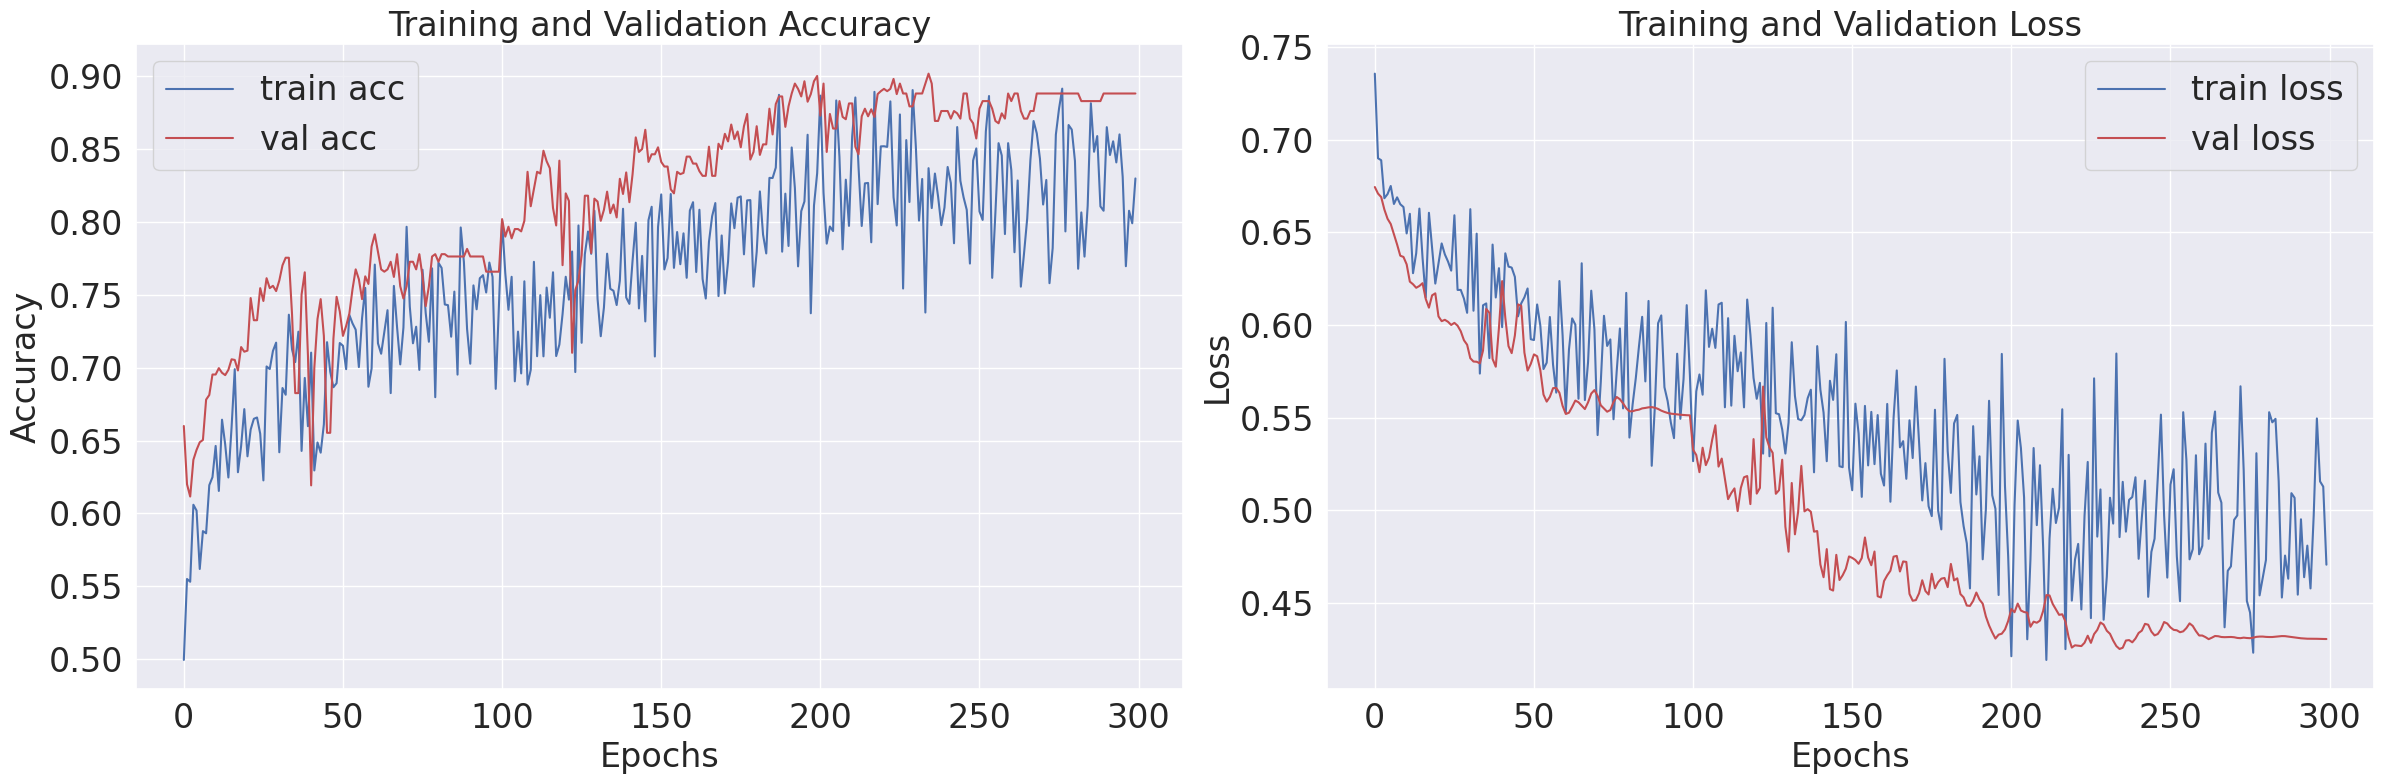

In [18]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 仮にepochsの数をトレーニングデータの長さから取得する
epochs = len(train_acc_list)  # train_acc_listの長さを使用

train_acc = []
train_loss = []
val_acc = []
val_loss = []

# 各リストをnumpy配列に変換し、リストに追加
for i in range(epochs):
    train_acc.append(train_acc_list[i].detach().cpu().numpy())
    train_loss.append(train_loss_list[i].detach().cpu().numpy())
    val_acc.append(val_acc_list[i].detach().cpu().numpy())
    val_loss.append(val_loss_list[i].detach().cpu().numpy())

# グラフ化
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.plot(range(epochs), train_acc, 'b', label='train acc')
ax1.plot(range(epochs), val_acc, 'r', label='val acc')
ax1.set_title('Training and Validation Accuracy',fontsize=24)
ax1.set_xlabel('Epochs',fontsize=24)
ax1.set_ylabel('Accuracy',fontsize=24)
ax1.legend(fontsize=24)
ax1.tick_params(labelsize=24)

ax2.plot(range(epochs), train_loss, 'b', label='train loss')
ax2.plot(range(epochs), val_loss, 'r', label='val loss')
ax2.set_title('Training and Validation Loss',fontsize=24)
ax2.tick_params(labelsize=24)
ax2.set_xlabel('Epochs',fontsize=24)
ax2.set_ylabel('Loss',fontsize=24)
ax2.legend(fontsize=24)
ax2.tick_params(labelsize=24)
plt.tight_layout()
plt.show()


Extracting validation set logits...


Extracting logits: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


Extracting test set logits...


Extracting logits: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibrating model...

Validation Set Results:


Calculating confidence interval: 100%|██████████| 1000/1000 [00:01<00:00, 652.40it/s]


Calibrated ROC AUC: 0.9476 [95% CI: 0.9159-0.9740]

Optimal Threshold Analysis (Validation Set):
Optimal threshold: 0.6195
Youden Index: 0.7888
Sensitivity: 0.8602
Specificity: 0.9286
Accuracy: 0.8927
F1-score: 0.8939

Test Set Results:


Calculating confidence interval: 100%|██████████| 1000/1000 [00:01<00:00, 670.01it/s]


Calibrated ROC AUC: 0.9909 [95% CI: 0.9728-1.0000]

Optimal Threshold Analysis (Test Set):
Using validation threshold: 0.6195
Sensitivity: 0.9714
Specificity: 0.9412
Accuracy: 0.9565
F1-score: 0.9577


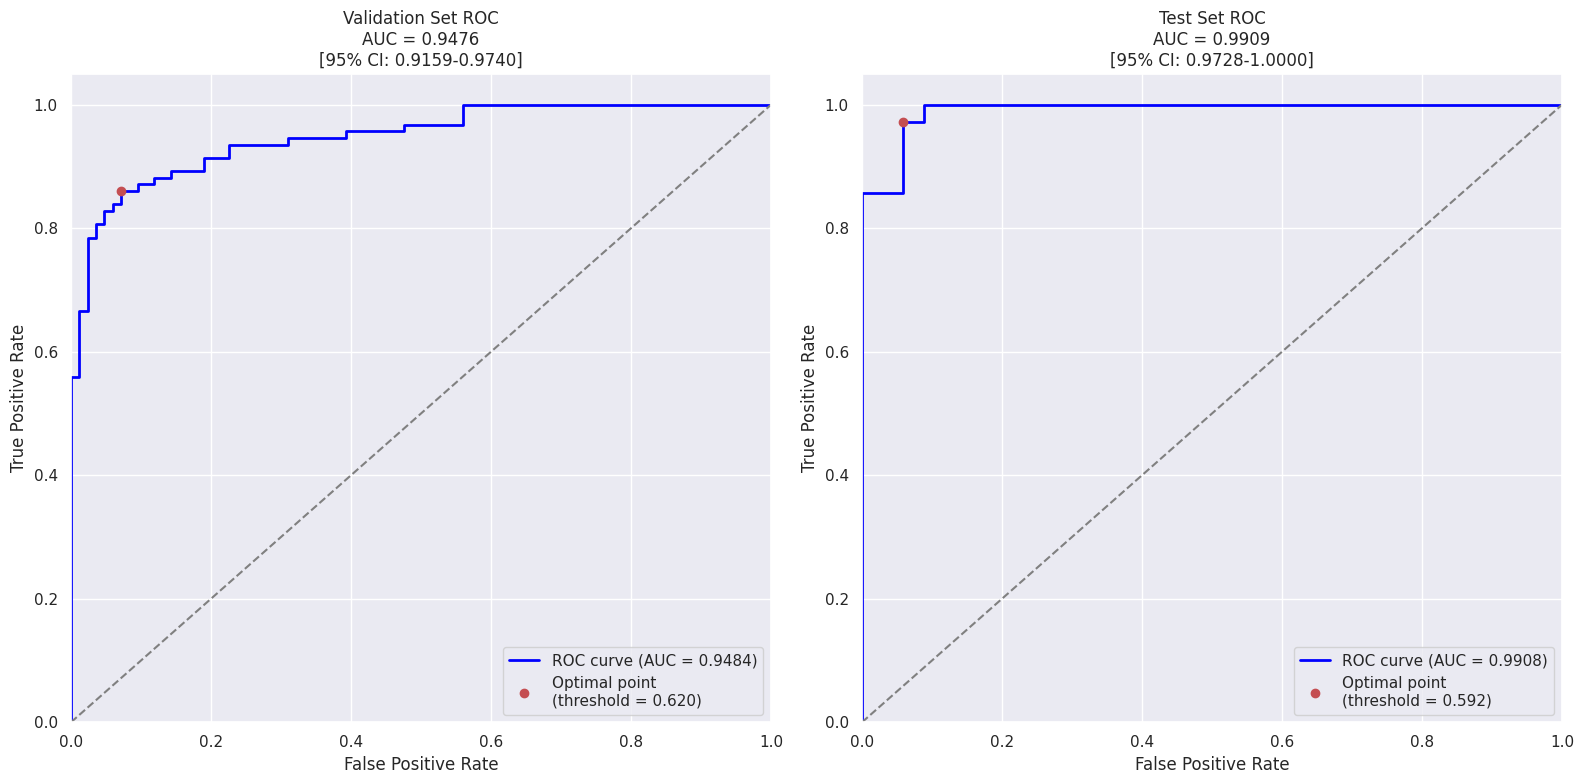

In [19]:
import glob
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats
from tqdm import tqdm
import seaborn as sns

def calculate_metrics(y_true, y_pred):
    """
    基本的な評価指標を計算
    """
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1_score
    }

def calculate_roc_auc_ci(y_true, y_pred, n_bootstraps=1000, confidence_level=0.95):
    """
    ROC-AUCスコアとその信頼区間を計算
    """
    bootstrapped_scores = []
    rng = np.random.RandomState(42)

    for i in tqdm(range(n_bootstraps), desc="Calculating confidence interval"):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    alpha = (1 - confidence_level)
    ci_lower = np.percentile(bootstrapped_scores, alpha/2 * 100)
    ci_upper = np.percentile(bootstrapped_scores, (1 - alpha/2) * 100)

    return np.mean(bootstrapped_scores), ci_lower, ci_upper

def calculate_optimal_threshold(y_true, y_pred_proba):
    """
    Youdenインデックスを用いて最適なカットオフ値を計算
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    youden_indices = tpr - fpr
    optimal_idx = np.argmax(youden_indices)
    optimal_threshold = thresholds[optimal_idx]

    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    youden_index = sensitivity + specificity - 1

    return {
        'threshold': optimal_threshold,
        'youden_index': youden_index,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'accuracy': accuracy,
        'precision': precision,
        'f1_score': f1_score,
        'confusion_matrix': {
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
        }
    }

def plot_roc_curve_with_optimal_point(y_true, y_pred_proba, title, ax=None):
    """
    ROC曲線と最適カットオフ点をプロット
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc_score = auc(fpr, tpr)

    optimal_metrics = calculate_optimal_threshold(y_true, y_pred_proba)
    optimal_threshold = optimal_metrics['threshold']

    optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # 既存のaxを使用するか、新しいfigureを作成
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # プロット処理をax.plotに変更
    ax.plot(fpr, tpr, color='blue', lw=2,
            label=f'ROC curve (AUC = {auc_score:.4f})')
    ax.plot(optimal_fpr, optimal_tpr, 'ro',
            label=f'Optimal point\n(threshold = {optimal_threshold:.3f})')

    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(True)

    return optimal_metrics

def extract_logits(model, loader, device):
    """
    モデルからロジットを抽出
    """
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in tqdm(loader, desc="Extracting logits"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

def calibrate_and_evaluate(model, valid_loader, test_loader, device):
    """
    モデルのキャリブレーションと評価を実行
    """
    print("Extracting validation set logits...")
    val_logits, val_targets = extract_logits(model, valid_loader, device)

    print("Extracting test set logits...")
    test_logits, test_targets = extract_logits(model, test_loader, device)

    # プラットスケーリングの設定と実行
    print("Calibrating model...")
    calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
    calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

    calibrator.fit(val_logits, val_targets)
    calibrated_model.fit(val_logits, val_targets)

    # 予測確率の取得
    val_probs = calibrated_model.predict_proba(val_logits)[:, 1]
    test_probs = calibrated_model.predict_proba(test_logits)[:, 1]

    # 検証セットの評価
    print("\nValidation Set Results:")
    val_auc, val_ci_lower, val_ci_upper = calculate_roc_auc_ci(val_targets, val_probs)
    print(f"Calibrated ROC AUC: {val_auc:.4f} [95% CI: {val_ci_lower:.4f}-{val_ci_upper:.4f}]")

    # 検証セットの最適カットオフ値を計算
    val_optimal_metrics = calculate_optimal_threshold(val_targets, val_probs)
    print("\nOptimal Threshold Analysis (Validation Set):")
    print(f"Optimal threshold: {val_optimal_metrics['threshold']:.4f}")
    print(f"Youden Index: {val_optimal_metrics['youden_index']:.4f}")
    print(f"Sensitivity: {val_optimal_metrics['sensitivity']:.4f}")
    print(f"Specificity: {val_optimal_metrics['specificity']:.4f}")
    print(f"Accuracy: {val_optimal_metrics['accuracy']:.4f}")
    print(f"F1-score: {val_optimal_metrics['f1_score']:.4f}")

    # テストセットの評価
    print("\nTest Set Results:")
    test_auc, test_ci_lower, test_ci_upper = calculate_roc_auc_ci(test_targets, test_probs)
    print(f"Calibrated ROC AUC: {test_auc:.4f} [95% CI: {test_ci_lower:.4f}-{test_ci_upper:.4f}]")

    # 検証セットで得られた最適カットオフ値をテストセットに適用
    test_metrics = calculate_optimal_threshold(test_targets, test_probs)
    print("\nOptimal Threshold Analysis (Test Set):")
    print(f"Using validation threshold: {val_optimal_metrics['threshold']:.4f}")
    print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
    print(f"Specificity: {test_metrics['specificity']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"F1-score: {test_metrics['f1_score']:.4f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    val_optimal_metrics = plot_roc_curve_with_optimal_point(
        val_targets, val_probs,
        f"Validation Set ROC\nAUC = {val_auc:.4f}\n[95% CI: {val_ci_lower:.4f}-{val_ci_upper:.4f}]",
        ax=ax1
    )

    test_optimal_metrics = plot_roc_curve_with_optimal_point(
        test_targets, test_probs,
        f"Test Set ROC\nAUC = {test_auc:.4f}\n[95% CI: {test_ci_lower:.4f}-{test_ci_upper:.4f}]",
        ax=ax2
    )

    plt.tight_layout()
    plt.show()

    # モデルを更新
    model.calibrator = calibrated_model

    return {
        'validation': {
            'auc': val_auc,
            'ci_lower': val_ci_lower,
            'ci_upper': val_ci_upper,
            'optimal_metrics': val_optimal_metrics,
            'predictions': val_probs
        },
        'test': {
            'auc': test_auc,
            'ci_lower': test_ci_lower,
            'ci_upper': test_ci_upper,
            'optimal_metrics': test_optimal_metrics,
            'predictions': test_probs
        }
    }

# メインの実行部分
if __name__ == "__main__":
    # モデルのトレーニング後に実行
    results = calibrate_and_evaluate(model, valid_loader, test_loader, device)

In [26]:
model_save_path = '/content/drive/MyDrive/swin_transformer_checkpoint20141220'
torch.save(model.state_dict(), model_save_path)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

def extract_logits(model, loader, device):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

# ロジットとターゲットを抽出
val_logits, val_targets = extract_logits(model, valid_loader, device)

# プラットスケーリングを使用してモデルをカリブレーション
calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

# 検証セットのロジットとターゲットを使って、ベースのcalibratorをフィッティング
calibrator.fit(val_logits, val_targets)
# 検証セットの確率を使ってフィッティング
calibrated_model.fit(val_logits, val_targets)

# カリブレーション後の確率を評価
calibrated_probs = calibrated_model.predict_proba(val_logits)[:, 1]

# パフォーマンス評価
roc_auc = roc_auc_score(val_targets, calibrated_probs)
print(f"Calibrated ROC AUC: {roc_auc:.4f}")

# 保存や他の用途で使用するためにモデルを更新
model.calibrator = calibrated_model

Calibrated ROC AUC: 0.9484


/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


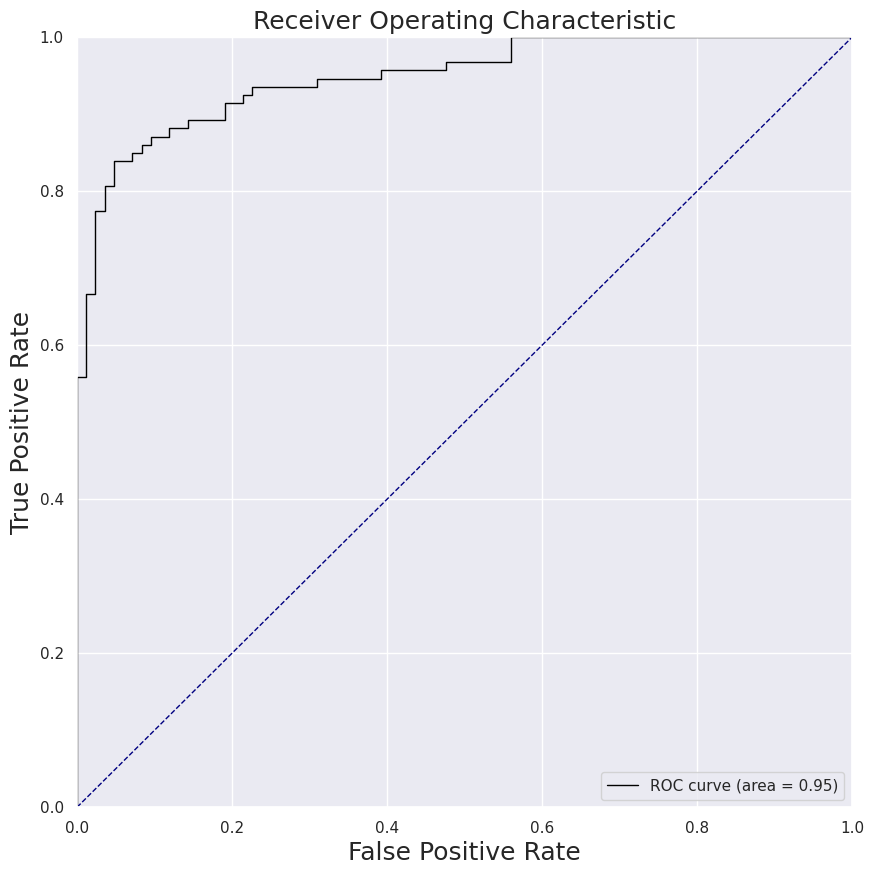

In [22]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, loader, device):
    # 真のラベルと予測確率を収集
    true_labels = []
    pred_probs = []

    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            # ソフトマックスを適用して確率を取得
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            pred_probs.extend(probabilities[:, 1].cpu().numpy())  # クラス1の確率を取得
            true_labels.extend(labels.cpu().numpy())

    # ROCカーブの計算
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # ROCカーブの描画
    plt.figure(figsize=(10, 10))
    lw = 1
    plt.plot(fpr, tpr, color='black',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 2], [0, 2], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver Operating Characteristic',fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# 使用例: 有効データローダーとデバイス情報を指定してROC曲線を描画
plot_roc_curve(model, valid_loader, device)


In [23]:
import pickle
# カリブレーターの保存
with open('/content/drive/MyDrive/model20141220.pkl', 'wb') as f:
    pickle.dump(calibrated_model, f)

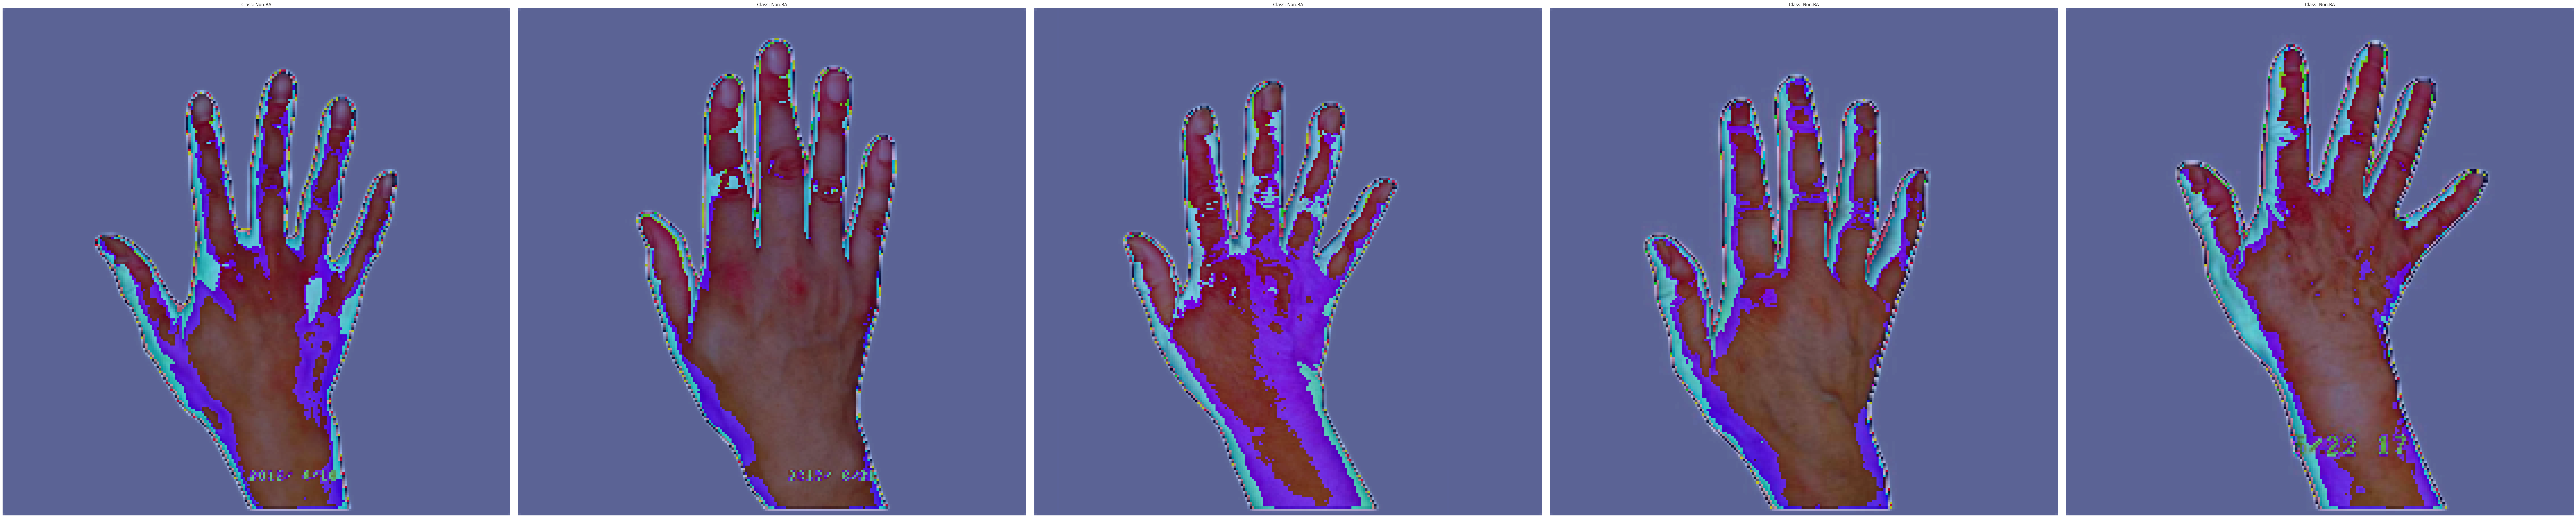

43210

In [24]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # Swin Transformerの最後のブロックを取得
        if hasattr(model, 'layers'):
            target_layer = model.layers[-1].blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        x = x.to(self.device)

        output = self.model(x)
        pred_class = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # Swin Transformerの特徴量マップの形状に合わせて処理
        feature_map = self.feature
        gradient_map = self.gradient

        # 重みの計算
        weights = gradient_map.mean(dim=(2, 3))  # Swinの場合、spatial dimensionsで平均を取る

        # CAMの計算
        batch_size = feature_map.shape[0]
        height = feature_map.shape[2]
        width = feature_map.shape[3]

        cam = torch.mul(feature_map, weights.view(batch_size, -1, 1, 1))
        cam = cam.sum(dim=1)  # チャネル方向に集約

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# 実行部分
grad_cam = GradCam(model, device)

images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

plt.figure(figsize=(100, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        heatmap = grad_cam(image.unsqueeze(0))
        overlayed = overlay_heatmap_to_image(image, heatmap)

        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()

<ipython-input-25-d4616c845f18>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_checkpoint201412

Overall Accuracy: 0.887


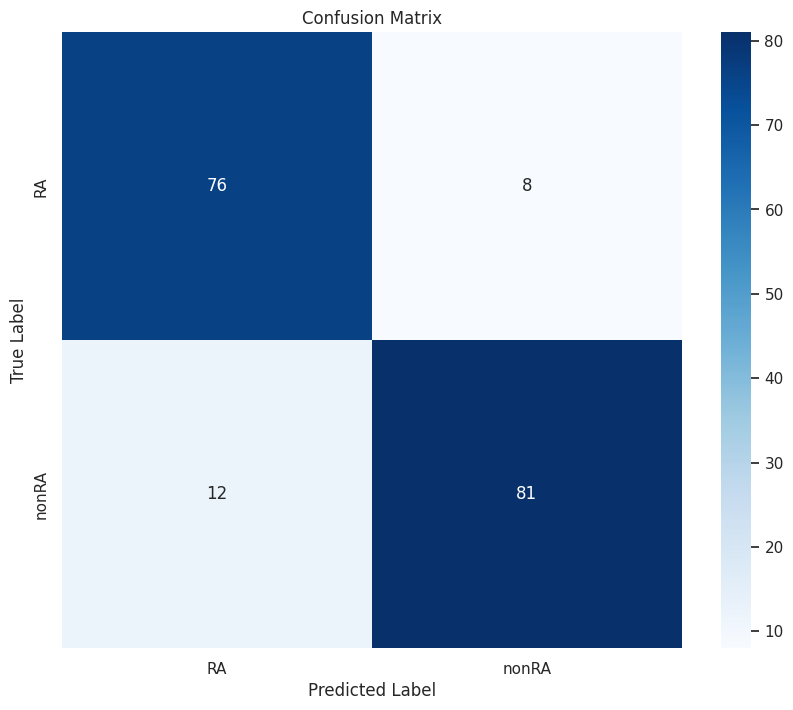

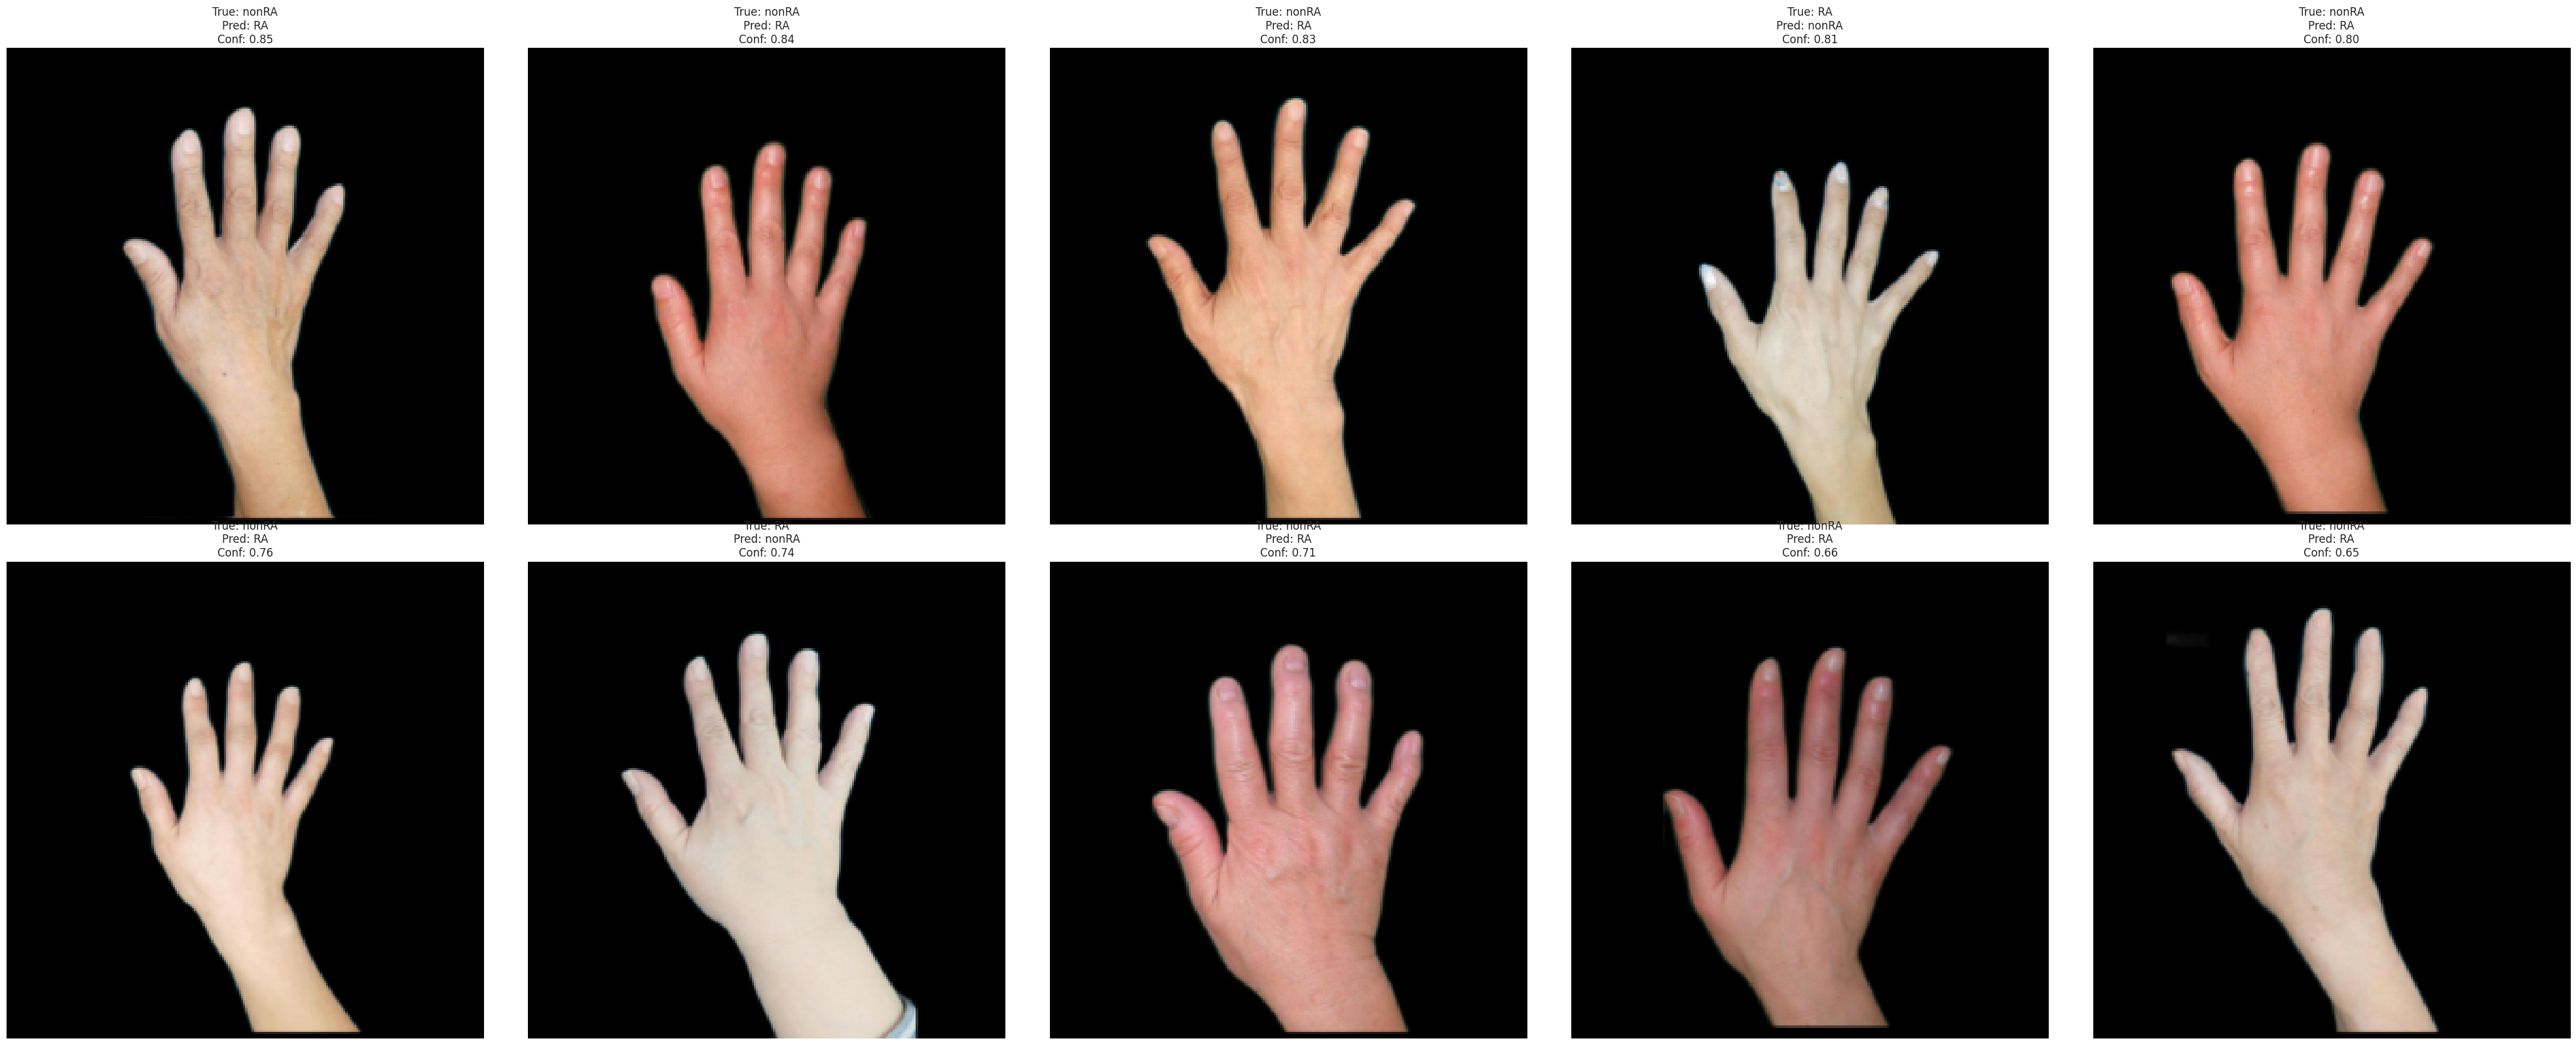

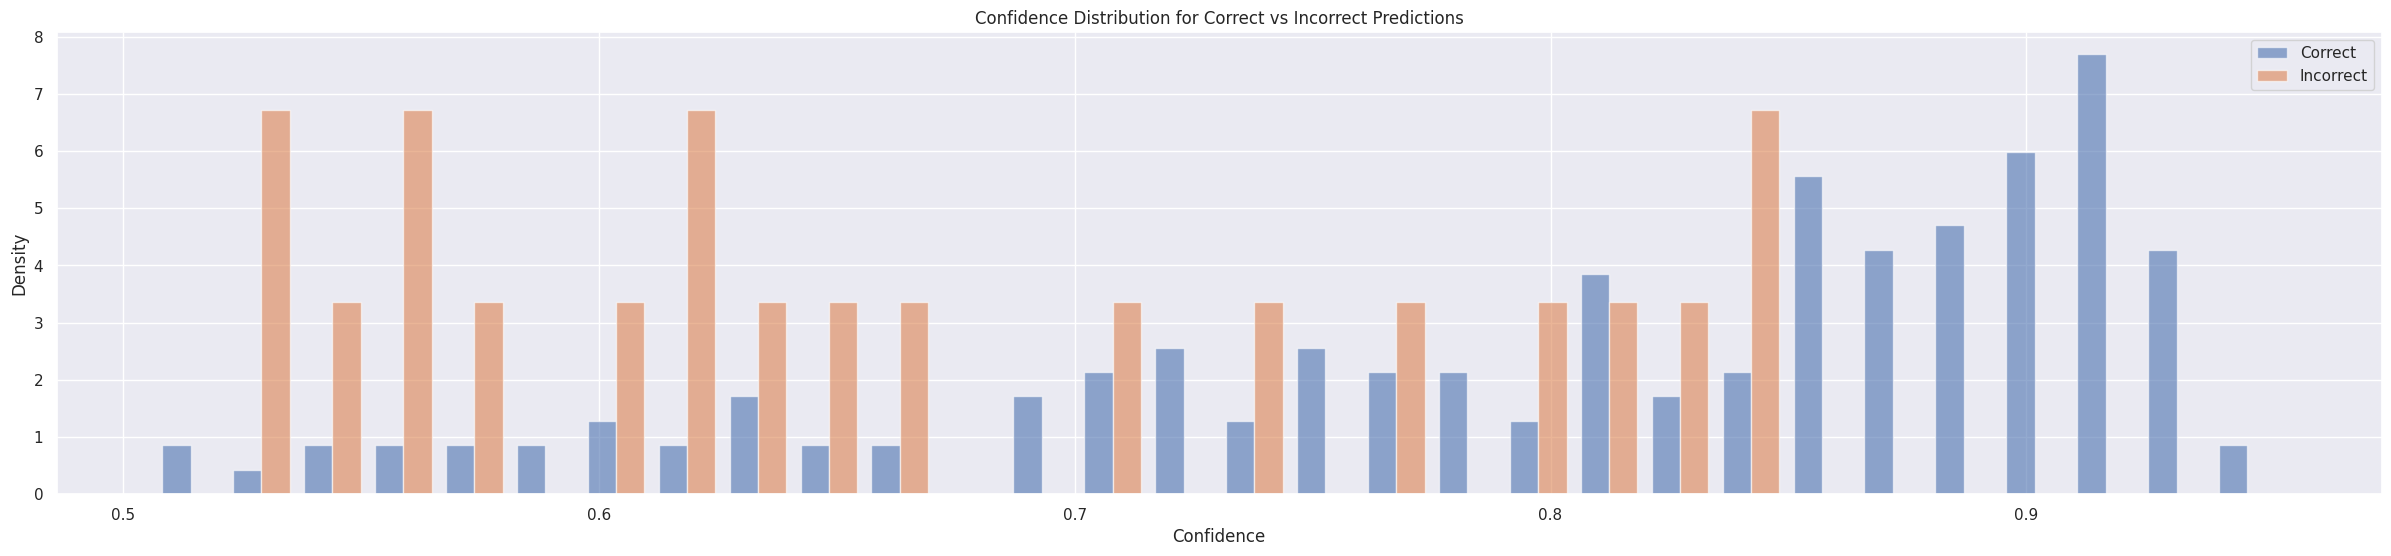


Class RA:
Accuracy: 0.905
Average confidence: 0.783
Samples: 84

Class nonRA:
Accuracy: 0.871
Average confidence: 0.798
Samples: 93


In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    images_list = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            images_list.extend(images.cpu())

    return np.array(predictions), np.array(true_labels), np.array(confidences), images_list

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names):
    misclassified_idx = np.where(predictions != true_labels)[0]

    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return

    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    n_samples = min(10, len(sorted_idx))
    fig, axes = plt.subplots(2, 5, figsize=(40, 16))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < n_samples:
            mis_idx = sorted_idx[idx]
            image = images_list[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            # 画像の正規化を元に戻す（必要に応じて調整）
            image = image.permute(1, 2, 0)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            image = torch.clamp(image, 0, 1)

            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(30, 6))

    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メインの実行コード
def main():
    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # クラス名の設定（あなたのデータセットに合わせて修正）
    class_names = ['RA', 'nonRA']  # あなたのクラス名に置き換えてください

    model = timm.create_model(
        'swin_base_patch4_window7_224.ms_in1k',
        pretrained=False,
        num_classes=2,
    )

    # モデルの読み込み（あなたの保存したモデルのパスに修正）
    model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_checkpoint20141201'))
    model = model.to(device)

    # 予測の実行
    predictions, true_labels, confidences, images_list = get_predictions(model, val_loader, device)

    # 全体の性能メトリクス
    accuracy = np.mean(predictions == true_labels)
    print(f"Overall Accuracy: {accuracy:.3f}")

    # 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names)

    # 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

if __name__ == '__main__':
    val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)  # あなたの検証用DataLoaderを設定

    main()